# Lockout  for Regression: Residential Building Data Set
Author: Wilmer Arbelo Gonzalez

## Import all necessary libraries

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import sys
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

## Datasets and DataLoaders

In [2]:
# Load data
def load_data(fname):
    """
    input (str or path): name of the folder with the data.
    This function reads the data, transforms it to tensors, and makes it
    global.
    """
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
# 
    df = pd.read_csv(os.path.join(fname, 'xtrain.csv'), index_col=False)
    xtrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xvalid.csv'), index_col=False)
    xvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtest.csv'), index_col=False)
    xtest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtrain_valid.csv'), index_col=False)
    xtrain_valid = torch.tensor(df.values).float()
# 
    df = pd.read_csv(os.path.join(fname, 'ytrain.csv'), index_col=False)
    ytrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'yvalid.csv'), index_col=False)
    yvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'ytest.csv'), index_col=False)
    ytest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'ytrain_valid.csv'), index_col=False)
    ytrain_valid = torch.tensor(df.values).float()


In [3]:
# Transform DataFrame to Tensor
def df_to_tensor():
    """
    This function transforms DataFrames to tensors and makes them global.
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
# 
    xtrain = torch.tensor(xtrain.values).float()
    xvalid = torch.tensor(xvalid.values).float()
    xtest = torch.tensor(xtest.values).float()
# 
    ytrain = torch.tensor(ytrain.values).float()
    yvalid = torch.tensor(yvalid.values).float()
    ytest = torch.tensor(ytest.values).float()

### Read and Clean Data

In [5]:
# DATASET INFO:
# Totally 105: 
# - 8 project physical and financial variables, 
# - 19 economic variables 
# - indices in 5 time lag numbers (5*19 = 95)
# - two output variables that are construction costs and sale prices

# Read Datasets
df = pd.read_excel('dataset_05ResidentialBuilding/Residential_Building_Data_Set.xlsx', 
                   sheet_name = 'Data',
                   engine = 'openpyxl',
                   skiprows = 1)
# Clean Datasets
df.drop(columns=['START YEAR', 'START QUARTER', 'COMPLETION YEAR', 'COMPLETION QUARTER'],
        inplace=True)

# .change column names
cols = df.columns.tolist()
for i in range(len(cols)):
    cols[i] = cols[i].lower()
    cols[i] = cols[i].replace('-', '_')
    cols[i] = cols[i].replace('.', '_')
    cols[i] = cols[i].strip()
    cols[i] = cols[i][:1] + cols[i][2:]
df.columns = cols

# .most of the cleaning
cols_cat = []
cols_num = []
target = ['v9', 'v10']
for col in cols:
    if df.dtypes[col] == "object":
        df[col] = df[col].str.lower()
        df[col] = df[col].str.replace('-', '_')
        df[col] = df[col].str.replace('&', '_')
        df[col] = df[col].str.strip()
        df[col] = df[col].replace('?', np.nan)
        df[col] = df[col].astype("category")
        if col not in target:
            cols_cat.append(col)
    else:
        df[col] = df[col].astype(float)
        if col not in target:
            cols_num.append(col)

print('- Categorical:')
print(cols_cat, '\n')
print('- Continuous:')
print(cols_num, '\n')
print('- Target:', target, '\n')

print("- Dataset size: {} points\n".format(len(df)))
print("- Missing values: {} points\n".format(df.isna().sum().sum()))

- Categorical:
[] 

- Continuous:
['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v11_1', 'v12_1', 'v13_1', 'v14_1', 'v15_1', 'v16_1', 'v17_1', 'v18_1', 'v19_1', 'v20_1', 'v21_1', 'v22_1', 'v23_1', 'v24_1', 'v25_1', 'v26_1', 'v27_1', 'v28_1', 'v29_1', 'v11_2', 'v12_2', 'v13_2', 'v14_2', 'v15_2', 'v16_2', 'v17_2', 'v18_2', 'v19_2', 'v20_2', 'v21_2', 'v22_2', 'v23_2', 'v24_2', 'v25_2', 'v26_2', 'v27_2', 'v28_2', 'v29_2', 'v11_3', 'v12_3', 'v13_3', 'v14_3', 'v15_3', 'v16_3', 'v17_3', 'v18_3', 'v19_3', 'v20_3', 'v21_3', 'v22_3', 'v23_3', 'v24_3', 'v25_3', 'v26_3', 'v27_3', 'v28_3', 'v29_3', 'v11_4', 'v12_4', 'v13_4', 'v14_4', 'v15_4', 'v16_4', 'v17_4', 'v18_4', 'v19_4', 'v20_4', 'v21_4', 'v22_4', 'v23_4', 'v24_4', 'v25_4', 'v26_4', 'v27_4', 'v28_4', 'v29_4'] 

- Target: ['v9', 'v10'] 

- Dataset size: 372 points

- Missing values: 0 points



### Split and Save

In [6]:
# # Random seeds for the splits
# seed1 = torch.randint(0, 1000, (500,))
# seed2 = torch.randint(1001, 2000, (500,))
seed1 = pd.read_csv('seed1.csv', header=None).iloc[:,0].tolist()
seed2 = pd.read_csv('seed2.csv', header=None).iloc[:,0].tolist()

In [7]:
# Split data (function)
def split_data(dfX, dfy, seed1=0, seed2=42):
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
    xtrain_valid, xtest, ytrain_valid, ytest = train_test_split(dfX, dfy, 
                                                      test_size=0.2, 
                                                      random_state=seed1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_valid, ytrain_valid, 
                                                      test_size=0.25, 
                                                      random_state=seed2)

In [8]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest)
data_folder = 'dataset_05ResidentialBuilding'

X = df.drop(columns=target)
y = df[target]
split_data(X, y)

# Save data on disk
cols_all = xtrain.columns.tolist()

xtrain.to_csv(os.path.join(data_folder, 'xtrain.csv'), index=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid.csv'), index=False)
xtest.to_csv(os.path.join(data_folder, 'xtest.csv'), index=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid.csv'), index=False)
X.to_csv(os.path.join(data_folder, 'X.csv'), index=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain.csv'), index=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid.csv'), index=False)
ytest.to_csv(os.path.join(data_folder, 'ytest.csv'), index=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid.csv'), index=False)
y.to_csv(os.path.join(data_folder, 'y.csv'), index=False)

# 
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))
print("- xtrain_valid size: {}".format(xtrain_valid.shape))

- xtrain size: (222, 103)
- xvalid size: (75, 103)
- xtest size: (75, 103)
- xtrain_valid size: (297, 103)


### Create Datasets and DataLoaders

In [8]:
# Create Dataset class
class MyDataset(Dataset):
    '''
    Input:
        xtensor (torch tensor): data points; dimension [# of points, # of features]
        ytensor (torch tensor): y values; dimension [# of points]
    Output:
        the usual...
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx

In [9]:
# Instantiate DataLoaders
def make_DataLoaders(target_idx=0, batch_size=100000, num_workers = 0):
    """
    This function instantiate and makes global DataLoaders for training, 
    validation, and testing datasets. 
    """
# .create datasets
    train_dataset = MyDataset(xtrain, ytrain[:,target_idx])
    valid_dataset = MyDataset(xvalid, yvalid[:,target_idx])
    test_dataset = MyDataset(xtest, ytest[:,target_idx])
    
# .make dataloaders global variables
    global train_dataloader, valid_dataloader, test_dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    print('- train minibatches =', len(train_dataloader))
    print('- valid minibatches =', len(valid_dataloader))
    print('- test minibatches =', len(test_dataloader))

In [10]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


## Optimizer and Loss Function

In [11]:
# Set up SGD optimizer with a constant learning rate
def setup_SGD(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.SGD(model.parameters(), lr=lr, momentum=0,  weight_decay=0.0)

In [12]:
# Set up Adam optimizer with a constant learning rate
def setup_ADAM(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.Adam(model.parameters(), lr=lr,  weight_decay=0.0)

In [13]:
# Type of Loss Function
loss_type = nn.MSELoss(reduction='mean')

## Train model

In [14]:
# PyTorch sign function
def sgn(x):
    return torch.sign(x)

In [392]:
# Train model (regression)
def train_model(lr, features, layer_sizes, lock_flag=False, epochs=3000, 
                early_stop=300, fname='model'):
    """
    """
# Set seed of random generators (for reproducibility purposes)
#     torch.manual_seed(42)

# Instantiate Model and Optimizer
    model = MyNet(features, layer_sizes)
    if lock_flag == True:
        model.load_state_dict(torch.load(model_forward_name))
    model = model.to(device)
    optimizer = setup_SGD(model, lr)

# LOCKDOWN SECTION 1:
    if lock_flag == True:
        n_iterations = epochs*len(train_dataloader)
        layers = get_lockdown_layers(model)
        t0 = []
        t0_initial = []
        sign_w0 = []
        l = 0
        for layer in layers:
            ww = layer.weight.detach()
            t0.append(abs(ww).sum())
            sign_w0.append(torch.sign(ww))
            t0_initial.append(t0[l])
            l += 1
    
# DataFrames to store train/valid loss function
    train_loss = pd.DataFrame(columns=['iteration', 'loss'])
    valid_loss = pd.DataFrame(columns=['iteration', 'loss'])

# Initialize some local variables...
    iteration = 0
    best_iter = 0
    best_loss = np.inf
    stop_flag = 0

# Loop Over Number of Epochs
    iterator = tqdm.notebook.tqdm(range(1, epochs + 1), desc='Epochs loop')
    for n_epoch in iterator:
# 
# .Loop Over Mini-batches
        for ibatch, (xx, yy, _) in enumerate(train_dataloader, start=1):
#
# ..Compute Validation Loss
            model_dict = copy.deepcopy(model.state_dict())
            epoch_loss = valid_epoch(valid_dataloader, model, loss_type, device)
            valid_loss = valid_loss.append({'iteration': iteration + 1, 
                                            'loss': epoch_loss}, 
                                            ignore_index=True)
# ..Train Mini-batch:
            model.train()
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

# ..Compute Train Loss
            loss = loss_type(yy_pred.view(-1), yy)
            train_loss = train_loss.append({'iteration': iteration + 1,
                                            'loss': loss.item()}, 
                                           ignore_index=True)
# ..Backward Propagation
            optimizer.zero_grad()
            loss.backward()

# ..LOCKDOWN SECTION 2:
            if lock_flag == True:
                l = 0
                for layer in layers:
# ...weights and gradients (2D)
                    w2d = layer.weight.detach()
                    g2d = layer.weight.grad.detach()
                    w_shape = g2d.size()

# ...flattens weights and compute P(W)
                    w1d = torch.flatten(w2d)
                    Pw = abs(w1d).sum()

# ...find g=-grads, 'gamma', and sort gamma (in descending order)
                    p1d = 1.0
                    g1d = -torch.flatten(g2d)
                    gamma = abs(g1d)/(p1d + 1e-10)
                    _, indx1d = torch.sort(gamma, descending=True)

# ...Modify Gradients Accordingly:
                    grmin = torch.zeros(w_shape).fill_(1e-1).to(device)
                    layer.weight.grad = torch.sign(g2d)*torch.max(abs(g2d), grmin)
                    gr1d = torch.flatten(layer.weight.grad.detach())
                    pjsj = lr*abs(gr1d[indx1d])

# ...sign(g) != sign(w) elements
                    mask_ds = (sgn(g1d[indx1d]) != sgn(w1d[indx1d])) & (w1d[indx1d] != 0.0)
                    DS_sum = pjsj[mask_ds].sum()
                    pjsj[mask_ds] = 0.0
                    mask_dsc = ~mask_ds
                    indx1d_dsc = indx1d[mask_dsc]

# ...sum(pjsj), j={1,J-1}
                    left_side = torch.cumsum(pjsj, dim=0) - pjsj
                    pjsj_dsc = torch.zeros(len(g1d)).to(device)
                    pjsj_dsc[:] = pjsj[:]

# ...sum(pjsj) + Penalty, j={J+1,nJ}
                    mask_w0 = (w1d[indx1d] == 0.0)
                    pjsj_dsc[mask_w0] = 0.0
                    right_side = pjsj_dsc.sum() - torch.cumsum(pjsj_dsc, dim=0) + DS_sum - Pw + t0[l]

# ...delta_j and new steps
                    ds = right_side - left_side
                    mask_w0 = (~mask_w0).float()
                    pjsj_new = -mask_w0**(1-sgn(ds))*sgn(g1d[indx1d])*sgn(ds)*torch.min(pjsj, abs(ds))

# ...modify gradients
                    indx2d = np.unravel_index(indx1d_dsc.cpu(), shape=w_shape)
                    layer.weight.grad[indx2d] = pjsj_new[mask_dsc]/lr
                    l = l + 1

# ..Update Weights 
            optimizer.step()

# ..LOCKDOWN SECTION 3:
            if lock_flag == True:
# ...Set Weights That Change Signs to Zero
                l = 0
                for layer in layers:
                    ww = layer.weight.detach()
                    sign_w = sgn(ww)
                    mask0 = ((sign_w != sign_w0[l]) & (sign_w0[l] != 0.0))
                    with torch.no_grad():
                        layer.weight[mask0] = 0.0
                    sign_w0[l] = sign_w
                    
# ...Tighten Constraint
                    if iteration%step == 0:
                        t0[l] = (1.0 - iteration/n_iterations)*t0_initial[l]
                    l = l + 1
                    

# ..Early Stop
            batch_loss = valid_loss.iloc[iteration, 1]
            if batch_loss < best_loss:
                torch.save(model_dict, fname+"_best.pth")
                best_loss = batch_loss
                best_iter = iteration
            else:
                if iteration - best_iter >= early_stop:
                    stop_flag = 1
                    break
# 
            iteration += 1
# 
        if stop_flag == 1:
            break
# 
    if lock_flag == False:
        torch.save(model_dict, fname+"_last.pth")
    print("Summary:")
    print("-learning rate = {:.5f}".format(lr))
    if stop_flag == 1:
        print('-path 1 has early stopped:')
        print(' {:d} iterations with no improvement in valid loss.'.format(early_stop))
    print("-Model saved after iteration {:d}.".format(best_iter + 1))
    print("-Train.  Loss={:.7f}".format(train_loss.iloc[best_iter, 1]))
    print("-Valid.  Loss={:.7f}".format(valid_loss.iloc[best_iter, 1]))
# 
    return train_loss, valid_loss

In [80]:
# Evaluate one epoch (regression)
def valid_epoch(data_loader, model, loss_type, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function after one epoch.
    """
# Initialize some local variables
    loss_fun = 0.
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred.view(-1), yy)
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return loss_fun/n_points

## Results:

### Lasso

In [194]:
# Load data
load_data('dataset_05ResidentialBuilding')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [195]:
# Normalize data
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

scaler = StandardScaler()
scaler.fit(ytrain)
ytrain = scaler.transform(ytrain)
yvalid = scaler.transform(yvalid)
ytest  = scaler.transform(ytest)

#### Target 2

In [196]:
# Grid search space
target_idx = 1
grid_alpha = np.geomspace(5e-5, 1.0, num=500)
df_grid_loss = pd.DataFrame(columns = ['alpha', 'valid_mse', 'valid_r2'], 
                            index=range(len(grid_alpha)))

params = {'max_iter': 100000,
          'random_state': 42,
          'warm_start': True}

In [197]:
# Perform grid search
target_idx = 1
data_out = 'data_lasso_05ResidentialBuilding'
iterator = tqdm.notebook.tqdm(range(1, len(grid_alpha) + 1), desc='alpha-grid loop')
for n in iterator:
    irow = n-1
    params['alpha'] = grid_alpha[irow]
    log_reg = Lasso(**params).fit(xtrain, ytrain[:,target_idx])
    
    ypred = log_reg.predict(xvalid)
    val_mse = mean_squared_error(yvalid[:,target_idx], ypred, squared=True)
    val_r2  = r2_score(yvalid[:,target_idx], ypred)
    
    df_grid_loss.iloc[irow,:] = [params['alpha'], val_mse, val_r2]
    print("alpha={:.5f} | valid_mse={:.5f},  valid_r2={:.5f}".format(params['alpha'], 
                                                                     val_mse, 
                                                                     val_r2))
# .save grid search results
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss02.csv'), index=None)

alpha=0.00005 | valid_mse=0.05508,  valid_r2=0.94142
alpha=0.00005 | valid_mse=0.05416,  valid_r2=0.94240
alpha=0.00005 | valid_mse=0.05325,  valid_r2=0.94337
alpha=0.00005 | valid_mse=0.05237,  valid_r2=0.94431
alpha=0.00005 | valid_mse=0.05149,  valid_r2=0.94524
alpha=0.00006 | valid_mse=0.05061,  valid_r2=0.94618
alpha=0.00006 | valid_mse=0.04982,  valid_r2=0.94701
alpha=0.00006 | valid_mse=0.04903,  valid_r2=0.94786
alpha=0.00006 | valid_mse=0.04822,  valid_r2=0.94873
alpha=0.00006 | valid_mse=0.04757,  valid_r2=0.94941
alpha=0.00006 | valid_mse=0.04696,  valid_r2=0.95006
alpha=0.00006 | valid_mse=0.04632,  valid_r2=0.95074
alpha=0.00006 | valid_mse=0.04566,  valid_r2=0.95145
alpha=0.00006 | valid_mse=0.04500,  valid_r2=0.95214
alpha=0.00007 | valid_mse=0.04443,  valid_r2=0.95275
alpha=0.00007 | valid_mse=0.04389,  valid_r2=0.95333
alpha=0.00007 | valid_mse=0.04333,  valid_r2=0.95392
alpha=0.00007 | valid_mse=0.04295,  valid_r2=0.95432
alpha=0.00007 | valid_mse=0.04259,  valid_r2=0

alpha=0.00120 | valid_mse=0.03271,  valid_r2=0.96522
alpha=0.00122 | valid_mse=0.03274,  valid_r2=0.96518
alpha=0.00125 | valid_mse=0.03278,  valid_r2=0.96514
alpha=0.00127 | valid_mse=0.03282,  valid_r2=0.96510
alpha=0.00130 | valid_mse=0.03286,  valid_r2=0.96506
alpha=0.00132 | valid_mse=0.03290,  valid_r2=0.96501
alpha=0.00135 | valid_mse=0.03295,  valid_r2=0.96496
alpha=0.00138 | valid_mse=0.03297,  valid_r2=0.96493
alpha=0.00140 | valid_mse=0.03305,  valid_r2=0.96485
alpha=0.00143 | valid_mse=0.03313,  valid_r2=0.96477
alpha=0.00146 | valid_mse=0.03319,  valid_r2=0.96470
alpha=0.00149 | valid_mse=0.03326,  valid_r2=0.96463
alpha=0.00152 | valid_mse=0.03333,  valid_r2=0.96456
alpha=0.00155 | valid_mse=0.03341,  valid_r2=0.96447
alpha=0.00158 | valid_mse=0.03349,  valid_r2=0.96438
alpha=0.00161 | valid_mse=0.03357,  valid_r2=0.96430
alpha=0.00164 | valid_mse=0.03363,  valid_r2=0.96423
alpha=0.00168 | valid_mse=0.03370,  valid_r2=0.96416
alpha=0.00171 | valid_mse=0.03376,  valid_r2=0

alpha=0.06594 | valid_mse=0.04227,  valid_r2=0.95505
alpha=0.06726 | valid_mse=0.04237,  valid_r2=0.95494
alpha=0.06861 | valid_mse=0.04248,  valid_r2=0.95482
alpha=0.06999 | valid_mse=0.04261,  valid_r2=0.95469
alpha=0.07139 | valid_mse=0.04274,  valid_r2=0.95455
alpha=0.07282 | valid_mse=0.04287,  valid_r2=0.95441
alpha=0.07428 | valid_mse=0.04295,  valid_r2=0.95432
alpha=0.07577 | valid_mse=0.04304,  valid_r2=0.95423
alpha=0.07729 | valid_mse=0.04314,  valid_r2=0.95412
alpha=0.07884 | valid_mse=0.04325,  valid_r2=0.95401
alpha=0.08042 | valid_mse=0.04337,  valid_r2=0.95388
alpha=0.08203 | valid_mse=0.04345,  valid_r2=0.95379
alpha=0.08367 | valid_mse=0.04353,  valid_r2=0.95371
alpha=0.08535 | valid_mse=0.04362,  valid_r2=0.95362
alpha=0.08706 | valid_mse=0.04371,  valid_r2=0.95352
alpha=0.08881 | valid_mse=0.04382,  valid_r2=0.95340
alpha=0.09059 | valid_mse=0.04393,  valid_r2=0.95328
alpha=0.09240 | valid_mse=0.04406,  valid_r2=0.95314
alpha=0.09425 | valid_mse=0.04420,  valid_r2=0

In [198]:
# Display grid search results
data_out = 'data_lasso_05ResidentialBuilding'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss02.csv'))

idx = df_grid_loss.valid_mse.idxmin()
best_alpha = df_grid_loss.iloc[idx, 0]
best_mse   = df_grid_loss.iloc[idx, 1]
print("Best parameters:")
print("- Best alpha = {:.5f}".format(best_alpha))
print("- Best valid loss = {}".format(best_mse))

Best parameters:
- Best alpha = 0.00071
- Best valid loss = 0.031988215


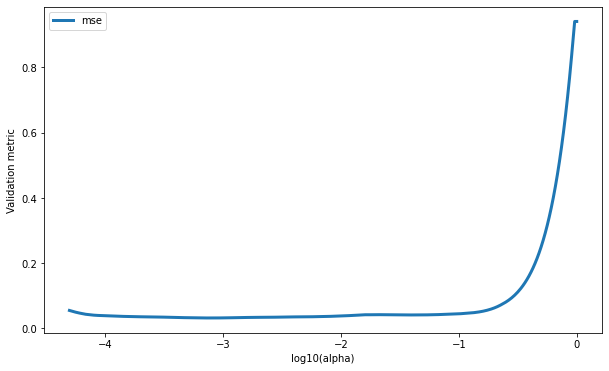

In [199]:
# Plot Loss vs point in grid search
data_out = 'data_lasso_05ResidentialBuilding'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss02.csv'))
fig, axes = plt.subplots(figsize=(10,6))
# axes.scatter(np.log10(df_grid_loss.alpha), df_grid_loss['valid_mse'], s=10)
axes.plot(np.log10(df_grid_loss.alpha), df_grid_loss['valid_mse'], label='mse', linewidth=3)
# axes.scatter(df_grid_loss.index, df_grid_loss['valid_r2'])
# axes.plot(df_grid_loss.index, df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(alpha)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [200]:
# Train with best hyperparameters
target_idx = 1
params['alpha'] = best_alpha
log_reg = Lasso(**params).fit(xtrain, ytrain[:,target_idx])

In [201]:
# Save model and model's best params
data_out = 'data_lasso_05ResidentialBuilding'
joblib.dump(log_reg, os.path.join(data_out, 'lasso_model02.pkl'))
print("model saved at: '{}'".format(os.path.join(data_out, 'lasso_model02.pkl')))

best_params = {}
best_params['alpha'] = best_alpha
with open(os.path.join(data_out, 'lasso_best_params02.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'lasso_best_params02.json')))

model saved at: 'data_lasso_05ResidentialBuilding/lasso_model02.pkl'
best params saved at: 'data_lasso_05ResidentialBuilding/lasso_best_params02.json'


In [202]:
# Find MSE, R2, Accuracy, etc...
target_idx = 1
data_out = 'data_lasso_05ResidentialBuilding'
model = joblib.load(os.path.join(data_out, 'lasso_model02.pkl'))

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['mse', 'r2'])

ypred = model.predict(xtrain)
df_results.loc['train', 'mse'] = mean_squared_error(ytrain[:,target_idx], ypred, squared=True)
df_results.loc['train', 'r2']   = r2_score(ytrain[:,target_idx], ypred)

ypred = model.predict(xvalid)
df_results.loc['valid', 'mse'] = mean_squared_error(yvalid[:,target_idx], ypred, squared=True)
df_results.loc['valid', 'r2']   = r2_score(yvalid[:,target_idx], ypred)

ypred = model.predict(xtest)
df_results.loc['test', 'mse'] = mean_squared_error(ytest[:,target_idx], ypred, squared=True)
df_results.loc['test', 'r2']   = r2_score(ytest[:,target_idx], ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_lasso02.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_lasso02.csv')))
df_results.head()

model results saved at: 'data_lasso_05ResidentialBuilding/results_target_lasso02.csv'


,mse,r2
train,0.0192427,0.980757
valid,0.0319882,0.965982
test,0.0457201,0.961424


In [204]:
# Find Accuracy +/- STD
target_idx = 1
data_out = 'data_lasso_05ResidentialBuilding/partitions'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])

model = joblib.load('data_lasso_05ResidentialBuilding/lasso_model02.pkl')

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_05ResidentialBuilding/X.csv')
    y = pd.read_csv('dataset_05ResidentialBuilding/y.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)
    
    scaler = StandardScaler()
    scaler.fit(ytrain)
    ytrain = scaler.transform(ytrain)
    yvalid = scaler.transform(yvalid)
    ytest  = scaler.transform(ytest)
    
# .train model
    model.fit(xtrain, ytrain[:,target_idx])
    
# .compute/save accuracy
    ypred = model.predict(xtrain)
    df_results.loc[n, 'train_mse'] = mean_squared_error(ytrain[:,target_idx], ypred, squared=True)
    df_results.loc[n, 'train_r2']   = r2_score(ytrain[:,target_idx], ypred)

    ypred = model.predict(xvalid)
    df_results.loc[n, 'valid_mse'] = mean_squared_error(yvalid[:,target_idx], ypred, squared=True)
    df_results.loc[n, 'valid_r2']   = r2_score(yvalid[:,target_idx], ypred)

    ypred = model.predict(xtest)
    df_results.loc[n, 'test_mse'] = mean_squared_error(ytest[:,target_idx], ypred, squared=True)
    df_results.loc[n, 'test_r2']   = r2_score(ytest[:,target_idx], ypred)

    joblib.dump(model, os.path.join(data_out, 'lasso_model02_'+str(n)+'.pkl'))
    df_results.to_csv('data_lasso_05ResidentialBuilding/accuracy_lasso02.csv', index=True)

In [205]:
# Display results
data_out = 'data_lasso_05ResidentialBuilding'
accuracy = pd.read_csv(os.path.join(data_out, 'accuracy_lasso02.csv'))
print("Train mse = {:.5f} +/- {:.5f}".format(accuracy['train_mse'].mean(), 
                                              accuracy['train_mse'].std()))
print("Valid mse = {:.5f} +/- {:.5f}".format(accuracy['valid_mse'].mean(), 
                                              accuracy['valid_mse'].std()))
print("Test mse = {:.5f} +/- {:.5f}".format(accuracy['test_mse'].mean(), 
                                             accuracy['test_mse'].std()))

print("")
print("Train r2 = {:.5f} +/- {:.5f}".format(accuracy['train_r2'].mean(), 
                                            accuracy['train_r2'].std()))
print("Valid r2 = {:.5f} +/- {:.5f}".format(accuracy['valid_r2'].mean(), 
                                            accuracy['valid_r2'].std()))
print("Test r2 = {:.5f} +/- {:.5f}".format(accuracy['test_r2'].mean(), 
                                           accuracy['test_r2'].std()))

Train mse = 0.01752 +/- 0.00456
Valid mse = 0.04566 +/- 0.02597
Test mse = 0.04218 +/- 0.02413

Train r2 = 0.98248 +/- 0.00456
Valid r2 = 0.95696 +/- 0.01824
Test r2 = 0.95922 +/- 0.01951


### Gradient Boosting

In [243]:
# Load data
load_data('dataset_05ResidentialBuilding')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [244]:
# Normalize data
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

scaler = StandardScaler()
scaler.fit(ytrain)
ytrain = scaler.transform(ytrain)
yvalid = scaler.transform(yvalid)
ytest  = scaler.transform(ytest)

#### Target 2: xgb native api

In [245]:
# Build DMatrices
target_idx = 1
dtrain = xgb.DMatrix(data=xtrain, label=ytrain[:,target_idx], nthread=10, feature_names=cols_all)
dvalid = xgb.DMatrix(data=xvalid, label=yvalid[:,target_idx], nthread=10, feature_names=cols_all)
dtest  = xgb.DMatrix(data=xtest,  label=ytest[:,target_idx],  nthread=10, feature_names=cols_all)

valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

In [228]:
# Grid search space
grid_eta   = np.geomspace(0.01, 1.0, num=200)
grid_depth = [1, 2, 3, 4, 5]
grid_param = [(eta, max_depth) for eta in grid_eta
                               for max_depth in grid_depth]

param = [('eta', 0.01), 
         ('max_depth', 2), 
         ('objective', 'reg:squarederror'), 
         ('nthread', 10),
         ('eval_metric', 'rmse')
]

In [229]:
# Perform grid search
data_out = 'data_xgb_05ResidentialBuilding'
df_grid_loss = pd.DataFrame(columns = ['eta', 'max_depth', 'valid_loss'], 
                            index = range(len(grid_param)))
i = 0
for eta, max_depth in grid_param:
    param[0] = ('eta', eta)
    param[1] = ('max_depth', max_depth)
    
    xgb_clf = xgb.train(param, dtrain, 
                        num_boost_round = 5000, 
                        evals = valid_list, 
                        early_stopping_rounds = 20, 
                        verbose_eval = False)
    
    print("eta={:.5f}, max_depth={} | valid_loss={:.5f} (iters={})".format(eta, 
                                                                          max_depth, 
                                                                          xgb_clf.best_score, 
                                                                          xgb_clf.best_iteration))
    df_grid_loss.iloc[i,:] = [eta, max_depth, xgb_clf.best_score]
    i += 1
    
# .save grid search results
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss02.csv'), index=None)

eta=0.01000, max_depth=1 | valid_loss=0.16524 (iters=1749)
eta=0.01000, max_depth=2 | valid_loss=0.16138 (iters=1055)
eta=0.01000, max_depth=3 | valid_loss=0.15699 (iters=1155)
eta=0.01000, max_depth=4 | valid_loss=0.16281 (iters=1129)
eta=0.01000, max_depth=5 | valid_loss=0.17250 (iters=871)
eta=0.01023, max_depth=1 | valid_loss=0.16553 (iters=1725)
eta=0.01023, max_depth=2 | valid_loss=0.15729 (iters=1503)
eta=0.01023, max_depth=3 | valid_loss=0.15782 (iters=820)
eta=0.01023, max_depth=4 | valid_loss=0.16288 (iters=1067)
eta=0.01023, max_depth=5 | valid_loss=0.17327 (iters=1074)
eta=0.01047, max_depth=1 | valid_loss=0.16551 (iters=1670)
eta=0.01047, max_depth=2 | valid_loss=0.15807 (iters=1361)
eta=0.01047, max_depth=3 | valid_loss=0.15656 (iters=1120)
eta=0.01047, max_depth=4 | valid_loss=0.16252 (iters=1182)
eta=0.01047, max_depth=5 | valid_loss=0.17381 (iters=754)
eta=0.01072, max_depth=1 | valid_loss=0.16559 (iters=1608)
eta=0.01072, max_depth=2 | valid_loss=0.15823 (iters=1349)


eta=0.01912, max_depth=2 | valid_loss=0.15623 (iters=776)
eta=0.01912, max_depth=3 | valid_loss=0.16104 (iters=459)
eta=0.01912, max_depth=4 | valid_loss=0.16141 (iters=731)
eta=0.01912, max_depth=5 | valid_loss=0.17238 (iters=624)
eta=0.01956, max_depth=1 | valid_loss=0.16476 (iters=903)
eta=0.01956, max_depth=2 | valid_loss=0.15740 (iters=784)
eta=0.01956, max_depth=3 | valid_loss=0.15445 (iters=625)
eta=0.01956, max_depth=4 | valid_loss=0.16234 (iters=583)
eta=0.01956, max_depth=5 | valid_loss=0.17291 (iters=396)
eta=0.02002, max_depth=1 | valid_loss=0.16514 (iters=934)
eta=0.02002, max_depth=2 | valid_loss=0.15650 (iters=748)
eta=0.02002, max_depth=3 | valid_loss=0.15545 (iters=644)
eta=0.02002, max_depth=4 | valid_loss=0.16523 (iters=706)
eta=0.02002, max_depth=5 | valid_loss=0.17169 (iters=556)
eta=0.02049, max_depth=1 | valid_loss=0.16604 (iters=842)
eta=0.02049, max_depth=2 | valid_loss=0.15849 (iters=721)
eta=0.02049, max_depth=3 | valid_loss=0.16159 (iters=416)
eta=0.02049, m

eta=0.03654, max_depth=5 | valid_loss=0.17411 (iters=200)
eta=0.03740, max_depth=1 | valid_loss=0.16481 (iters=482)
eta=0.03740, max_depth=2 | valid_loss=0.15740 (iters=433)
eta=0.03740, max_depth=3 | valid_loss=0.15729 (iters=266)
eta=0.03740, max_depth=4 | valid_loss=0.16419 (iters=350)
eta=0.03740, max_depth=5 | valid_loss=0.17400 (iters=226)
eta=0.03827, max_depth=1 | valid_loss=0.16312 (iters=480)
eta=0.03827, max_depth=2 | valid_loss=0.15742 (iters=402)
eta=0.03827, max_depth=3 | valid_loss=0.15321 (iters=395)
eta=0.03827, max_depth=4 | valid_loss=0.16298 (iters=307)
eta=0.03827, max_depth=5 | valid_loss=0.17239 (iters=204)
eta=0.03917, max_depth=1 | valid_loss=0.16398 (iters=470)
eta=0.03917, max_depth=2 | valid_loss=0.15653 (iters=369)
eta=0.03917, max_depth=3 | valid_loss=0.15358 (iters=612)
eta=0.03917, max_depth=4 | valid_loss=0.15757 (iters=496)
eta=0.03917, max_depth=5 | valid_loss=0.17079 (iters=184)
eta=0.04009, max_depth=1 | valid_loss=0.16479 (iters=411)
eta=0.04009, m

eta=0.07149, max_depth=4 | valid_loss=0.16384 (iters=168)
eta=0.07149, max_depth=5 | valid_loss=0.17306 (iters=137)
eta=0.07317, max_depth=1 | valid_loss=0.16690 (iters=241)
eta=0.07317, max_depth=2 | valid_loss=0.15624 (iters=182)
eta=0.07317, max_depth=3 | valid_loss=0.15708 (iters=314)
eta=0.07317, max_depth=4 | valid_loss=0.16474 (iters=166)
eta=0.07317, max_depth=5 | valid_loss=0.17231 (iters=112)
eta=0.07488, max_depth=1 | valid_loss=0.16609 (iters=238)
eta=0.07488, max_depth=2 | valid_loss=0.14860 (iters=361)
eta=0.07488, max_depth=3 | valid_loss=0.14792 (iters=281)
eta=0.07488, max_depth=4 | valid_loss=0.16842 (iters=132)
eta=0.07488, max_depth=5 | valid_loss=0.17412 (iters=132)
eta=0.07663, max_depth=1 | valid_loss=0.16804 (iters=221)
eta=0.07663, max_depth=2 | valid_loss=0.15090 (iters=310)
eta=0.07663, max_depth=3 | valid_loss=0.15399 (iters=251)
eta=0.07663, max_depth=4 | valid_loss=0.15947 (iters=254)
eta=0.07663, max_depth=5 | valid_loss=0.16996 (iters=144)
eta=0.07843, m

eta=0.13987, max_depth=4 | valid_loss=0.17477 (iters=72)
eta=0.13987, max_depth=5 | valid_loss=0.17195 (iters=54)
eta=0.14315, max_depth=1 | valid_loss=0.17330 (iters=134)
eta=0.14315, max_depth=2 | valid_loss=0.14809 (iters=192)
eta=0.14315, max_depth=3 | valid_loss=0.14878 (iters=177)
eta=0.14315, max_depth=4 | valid_loss=0.17274 (iters=87)
eta=0.14315, max_depth=5 | valid_loss=0.17483 (iters=54)
eta=0.14650, max_depth=1 | valid_loss=0.16737 (iters=118)
eta=0.14650, max_depth=2 | valid_loss=0.14283 (iters=175)
eta=0.14650, max_depth=3 | valid_loss=0.15890 (iters=138)
eta=0.14650, max_depth=4 | valid_loss=0.17666 (iters=142)
eta=0.14650, max_depth=5 | valid_loss=0.16989 (iters=126)
eta=0.14993, max_depth=1 | valid_loss=0.16539 (iters=100)
eta=0.14993, max_depth=2 | valid_loss=0.15161 (iters=184)
eta=0.14993, max_depth=3 | valid_loss=0.15586 (iters=194)
eta=0.14993, max_depth=4 | valid_loss=0.16935 (iters=87)
eta=0.14993, max_depth=5 | valid_loss=0.17748 (iters=96)
eta=0.15344, max_dep

eta=0.27364, max_depth=2 | valid_loss=0.16263 (iters=100)
eta=0.27364, max_depth=3 | valid_loss=0.15837 (iters=56)
eta=0.27364, max_depth=4 | valid_loss=0.17507 (iters=66)
eta=0.27364, max_depth=5 | valid_loss=0.17040 (iters=65)
eta=0.28005, max_depth=1 | valid_loss=0.17610 (iters=58)
eta=0.28005, max_depth=2 | valid_loss=0.16041 (iters=93)
eta=0.28005, max_depth=3 | valid_loss=0.17260 (iters=75)
eta=0.28005, max_depth=4 | valid_loss=0.17256 (iters=83)
eta=0.28005, max_depth=5 | valid_loss=0.17315 (iters=95)
eta=0.28661, max_depth=1 | valid_loss=0.17053 (iters=83)
eta=0.28661, max_depth=2 | valid_loss=0.14794 (iters=93)
eta=0.28661, max_depth=3 | valid_loss=0.17200 (iters=44)
eta=0.28661, max_depth=4 | valid_loss=0.17599 (iters=51)
eta=0.28661, max_depth=5 | valid_loss=0.17244 (iters=52)
eta=0.29332, max_depth=1 | valid_loss=0.17968 (iters=59)
eta=0.29332, max_depth=2 | valid_loss=0.14646 (iters=125)
eta=0.29332, max_depth=3 | valid_loss=0.16271 (iters=154)
eta=0.29332, max_depth=4 | v

eta=0.53536, max_depth=4 | valid_loss=0.19213 (iters=62)
eta=0.53536, max_depth=5 | valid_loss=0.18542 (iters=13)
eta=0.54789, max_depth=1 | valid_loss=0.20524 (iters=42)
eta=0.54789, max_depth=2 | valid_loss=0.19254 (iters=57)
eta=0.54789, max_depth=3 | valid_loss=0.19058 (iters=19)
eta=0.54789, max_depth=4 | valid_loss=0.20085 (iters=14)
eta=0.54789, max_depth=5 | valid_loss=0.18449 (iters=16)
eta=0.56072, max_depth=1 | valid_loss=0.20559 (iters=46)
eta=0.56072, max_depth=2 | valid_loss=0.19238 (iters=22)
eta=0.56072, max_depth=3 | valid_loss=0.18097 (iters=14)
eta=0.56072, max_depth=4 | valid_loss=0.20938 (iters=5)
eta=0.56072, max_depth=5 | valid_loss=0.18063 (iters=10)
eta=0.57384, max_depth=1 | valid_loss=0.20353 (iters=54)
eta=0.57384, max_depth=2 | valid_loss=0.18568 (iters=74)
eta=0.57384, max_depth=3 | valid_loss=0.17453 (iters=22)
eta=0.57384, max_depth=4 | valid_loss=0.18241 (iters=22)
eta=0.57384, max_depth=5 | valid_loss=0.19332 (iters=8)
eta=0.58728, max_depth=1 | valid_

In [230]:
# Display grid search results
data_out = 'data_xgb_05ResidentialBuilding'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss02.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_eta   = df_grid_loss.iloc[idx, 0]
best_depth = df_grid_loss.iloc[idx, 1]
best_loss  = df_grid_loss.iloc[idx, 2]
print("Best parameters:")
print("- Best eta = {:.3f}".format(best_eta))
print("- Best max_depth = {}".format(best_depth))
print("- Best valid loss = {}".format(best_loss))

Best parameters:
- Best eta = 0.146
- Best max_depth = 2
- Best valid loss = 0.142835


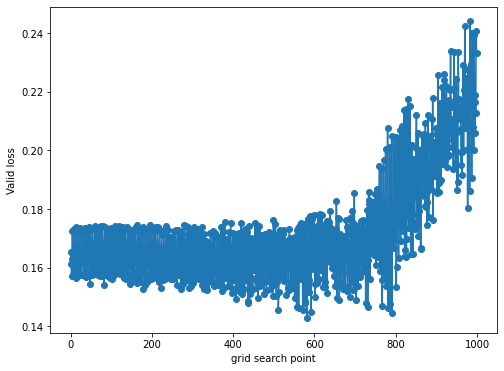

In [231]:
# Plot Loss vs point in grid search
data_out = 'data_xgb_05ResidentialBuilding'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss02.csv'))
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid loss")
plt.show()

In [232]:
# Train with best hyperparameters
param[0] = ('eta', best_eta)
param[1] = ('max_depth', best_depth)

evals_result = {}
xgb_clf = xgb.train(param, dtrain, 
                    num_boost_round = 5000, 
                    evals = valid_list, 
                    early_stopping_rounds = 50, 
                    verbose_eval = True, 
                    evals_result=evals_result)

[0]	train-rmse:0.97698	valid-rmse:0.93541
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.85692	valid-rmse:0.81288
[2]	train-rmse:0.75592	valid-rmse:0.70467
[3]	train-rmse:0.66852	valid-rmse:0.61328
[4]	train-rmse:0.59525	valid-rmse:0.54039
[5]	train-rmse:0.53257	valid-rmse:0.47257
[6]	train-rmse:0.48079	valid-rmse:0.41843
[7]	train-rmse:0.43178	valid-rmse:0.38089
[8]	train-rmse:0.39026	valid-rmse:0.34757
[9]	train-rmse:0.35739	valid-rmse:0.32149
[10]	train-rmse:0.32998	valid-rmse:0.30234
[11]	train-rmse:0.30345	valid-rmse:0.28181
[12]	train-rmse:0.28148	valid-rmse:0.26837
[13]	train-rmse:0.26268	valid-rmse:0.25648
[14]	train-rmse:0.24706	valid-rmse:0.24779
[15]	train-rmse:0.23397	valid-rmse:0.24177
[16]	train-rmse:0.21871	valid-rmse:0.23248
[17]	train-rmse:0.20818	valid-rmse:0.22607
[18]	train-rmse:0.19692	valid-rmse:0.21985
[19]	train-rmse:0.18789	valid-rmse:0.21545
[20]	

[186]	train-rmse:0.04791	valid-rmse:0.14339
[187]	train-rmse:0.04785	valid-rmse:0.14336
[188]	train-rmse:0.04778	valid-rmse:0.14326
[189]	train-rmse:0.04764	valid-rmse:0.14353
[190]	train-rmse:0.04742	valid-rmse:0.14394
[191]	train-rmse:0.04714	valid-rmse:0.14384
[192]	train-rmse:0.04707	valid-rmse:0.14363
[193]	train-rmse:0.04670	valid-rmse:0.14351
[194]	train-rmse:0.04640	valid-rmse:0.14353
[195]	train-rmse:0.04632	valid-rmse:0.14373
[196]	train-rmse:0.04602	valid-rmse:0.14352
[197]	train-rmse:0.04593	valid-rmse:0.14334
[198]	train-rmse:0.04571	valid-rmse:0.14352
[199]	train-rmse:0.04542	valid-rmse:0.14323
[200]	train-rmse:0.04528	valid-rmse:0.14325
[201]	train-rmse:0.04520	valid-rmse:0.14323
[202]	train-rmse:0.04514	valid-rmse:0.14337
[203]	train-rmse:0.04497	valid-rmse:0.14374
[204]	train-rmse:0.04469	valid-rmse:0.14364
[205]	train-rmse:0.04460	valid-rmse:0.14362
[206]	train-rmse:0.04454	valid-rmse:0.14341
[207]	train-rmse:0.04447	valid-rmse:0.14360
[208]	train-rmse:0.04441	valid-r

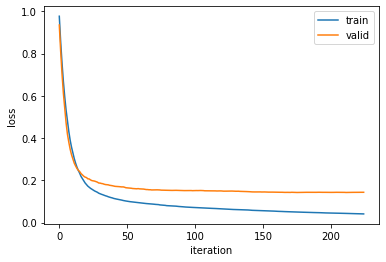

In [233]:
# Plot of train/valid loss vs iter
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(evals_result['train']['rmse'], label="train")
axes.plot(evals_result['valid']['rmse'], label="valid")
axes.legend()
axes.set_ylabel("loss")
axes.set_xlabel("iteration")
# axes.set_xticks(np.arange(0, len(evals_result['train']['logloss']), 1))
plt.show()

In [234]:
# Save model and model's best params
data_out = 'data_xgb_05ResidentialBuilding'
xgb_clf.save_model(os.path.join(data_out, 'xgb_model02.json'))
print("model saved at: '{}'".format(os.path.join(data_out, 'xgb_model02.json')))

best_params = {}
best_params['best_eta'] = best_eta
best_params['best_depth'] = int(best_depth)
with open(os.path.join(data_out, 'xgb_best_params02.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'xgb_best_params02.json')))

model saved at: 'data_xgb_05ResidentialBuilding/xgb_model02.json'
best params saved at: 'data_xgb_05ResidentialBuilding/xgb_best_params02.json'


In [235]:
# Save feature map
def ceate_feature_map(features, data_out):
    f = open(os.path.join(data_out, 'xgb_model_fmap02.txt'), 'w')
    i = 0
    for feat in features:
        f.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    f.close()

data_out = 'data_xgb_05ResidentialBuilding'
ceate_feature_map(cols_all, data_out)
print("feature map saved at: '{}'".format(os.path.join(data_out, 'xgb_model_fmap02.txt')))

feature map saved at: 'data_xgb_05ResidentialBuilding/xgb_model_fmap02.txt'


In [247]:
# Find MSE, R2, Accuracy, etc...
target_idx = 1
data_out = 'data_xgb_05ResidentialBuilding'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model02.json'))
df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['mse', 'r2'])

ypred = model.predict(dtrain)
df_results.loc['train', 'mse'] = mean_squared_error(ytrain[:,target_idx], ypred, squared=True)
df_results.loc['train', 'r2']  = r2_score(ytrain[:,target_idx], ypred)

ypred = model.predict(dvalid)
df_results.loc['valid', 'mse'] = mean_squared_error(yvalid[:,target_idx], ypred, squared=True)
df_results.loc['valid', 'r2']  = r2_score(yvalid[:,target_idx], ypred)

ypred = model.predict(dtest)
df_results.loc['test', 'mse'] = mean_squared_error(ytest[:,target_idx], ypred, squared=True)
df_results.loc['test', 'r2']  = r2_score(ytest[:,target_idx], ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_xgb02.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_xgb02.csv')))
df_results.head()

model results saved at: 'data_xgb_05ResidentialBuilding/results_target_xgb02.csv'


,mse,r2
train,0.00169527,0.998305
valid,0.0206157,0.978076
test,0.0341635,0.971175


In [249]:
# Find Accuracy +/- STD
target_idx = 1
data_out = 'data_xgb_05ResidentialBuilding/patitions'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])

with open('data_xgb_05ResidentialBuilding/xgb_best_params02.json') as f:
    best_params = json.load(f)
param = [('eta', best_params['best_eta']), 
         ('max_depth', best_params['best_depth']), 
         ('objective', 'reg:squarederror'), 
         ('nthread', 16),
         ('eval_metric', 'rmse')
]

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_05ResidentialBuilding/X.csv')
    y = pd.read_csv('dataset_05ResidentialBuilding/y.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)

    scaler = StandardScaler()
    scaler.fit(ytrain)
    ytrain = scaler.transform(ytrain)
    yvalid = scaler.transform(yvalid)
    ytest  = scaler.transform(ytest)
    
# .build DMatrices
    dtrain = xgb.DMatrix(data=xtrain, label=ytrain[:,target_idx], nthread=10)
    dvalid = xgb.DMatrix(data=xvalid, label=yvalid[:,target_idx], nthread=10)
    dtest  = xgb.DMatrix(data=xtest,  label=ytest[:,target_idx],  nthread=10)
    valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

# .train model
    evals_result = {}
    model = xgb.train(param, dtrain, 
                      num_boost_round = 5000, 
                      evals = valid_list, 
                      early_stopping_rounds = 20, 
                      verbose_eval = False, 
                      evals_result=evals_result)
    
# .compute/save accuracy
    ypred = model.predict(dtrain)
    df_results.loc[n, 'train_mse'] = mean_squared_error(ytrain[:,target_idx], ypred, squared=True)
    df_results.loc[n, 'train_r2']  = r2_score(ytrain[:,target_idx], ypred)

    ypred = model.predict(dvalid)
    df_results.loc[n, 'valid_mse'] = mean_squared_error(yvalid[:,target_idx], ypred, squared=True)
    df_results.loc[n, 'valid_r2']   = r2_score(yvalid[:,target_idx], ypred)

    ypred = model.predict(dtest)
    df_results.loc[n, 'test_mse'] = mean_squared_error(ytest[:,target_idx], ypred, squared=True)
    df_results.loc[n, 'test_r2']   = r2_score(ytest[:,target_idx], ypred)

    model.save_model(os.path.join(data_out, 'xgb_model02_'+str(n)+'.json'))
    df_results.to_csv('data_xgb_05ResidentialBuilding/accuracy_xgb02.csv', index=True)

In [250]:
# Display results
data_out = 'data_xgb_05ResidentialBuilding'
accuracy_xgb = pd.read_csv(os.path.join(data_out, 'accuracy_xgb02.csv'))
print("Train mse = {:.5f} +/- {:.5f}".format(accuracy_xgb['train_mse'].mean(), 
                                              accuracy_xgb['train_mse'].std()))
print("Valid mse = {:.5f} +/- {:.5f}".format(accuracy_xgb['valid_mse'].mean(), 
                                              accuracy_xgb['valid_mse'].std()))
print("Test mse = {:.5f} +/- {:.5f}".format(accuracy_xgb['test_mse'].mean(), 
                                             accuracy_xgb['test_mse'].std()))

print("")
print("Train r2 = {:.5f} +/- {:.5f}".format(accuracy_xgb['train_r2'].mean(), 
                                            accuracy_xgb['train_r2'].std()))
print("Valid r2 = {:.5f} +/- {:.5f}".format(accuracy_xgb['valid_r2'].mean(), 
                                            accuracy_xgb['valid_r2'].std()))
print("Test r2 = {:.5f} +/- {:.5f}".format(accuracy_xgb['test_r2'].mean(), 
                                           accuracy_xgb['test_r2'].std()))

Train mse = 0.00358 +/- 0.00213
Valid mse = 0.05383 +/- 0.03860
Test mse = 0.05042 +/- 0.03253

Train r2 = 0.99642 +/- 0.00213
Valid r2 = 0.95134 +/- 0.02509
Test r2 = 0.95306 +/- 0.02131


### Lockout

In [396]:
# Normalize Data Set
def normalize_data():
    """
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    xtrain = torch.from_numpy(scaler.transform(xtrain.numpy()))
    xvalid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    xtest = torch.from_numpy(scaler.transform(xtest.numpy()))
    
    scaler = StandardScaler()
    scaler.fit(ytrain.numpy())
    ytrain = torch.from_numpy(scaler.transform(ytrain.numpy()))
    yvalid = torch.from_numpy(scaler.transform(yvalid.numpy()))
    ytest = torch.from_numpy(scaler.transform(ytest.numpy()))

In [397]:
# Save output data
def save_output(data_out, f1, f2, f3, new_folder=False):
    """
    """
# Save relevant data
    if new_folder == True:
        dirs = os.listdir()
        if data_out in dirs:
            print("'{}' directory deleted.".format(data_out))
            shutil.rmtree(data_out)
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
        else:
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
# 
    train_loss.to_csv(os.path.join(data_out, f1), index=False)
    valid_loss.to_csv(os.path.join(data_out, f2), index=False)
    print("'{}' saved.".format(f1))
    print("'{}' saved.".format(f2))

    for m in f3:
        shutil.move(m, os.path.join(data_out, m))
        print("'{}' saved.".format(m))

#### Target 2: l1=5, l2=1; lockout=l1

In [476]:
# Set layers where lockdown is to be applied
def get_lockdown_layers(model):
    layers = [model.classifier[0]]
    return layers

In [477]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)#,
#             nn.ReLU(inplace=True),
#             nn.Linear(layer_sizes[1], layer_sizes[2], bias=True)#,
#             nn.ReLU(inplace=True),
#             nn.Linear(layer_sizes[2], layer_sizes[3], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [478]:
# Grid search space
target_idx = 0
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_mse', 'valid_r2'], 
                            index=range(len(grid_lrs)))

In [480]:
# Perform grid search (unconstrained)
target_idx = 1
layer_sizes = [5, 1]
epochs = 50000
data_in = 'dataset_05ResidentialBuilding'
data_out = "data_unconstrained_05ResidentialBuilding/lrs"
lock_flag = False

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders(target_idx=target_idx)
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    fname = 'model05_forward02_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_forward02_'+str(n)+'.csv', 
                'valid_forward02_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())

# .save grid search results
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], mse, r2]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_forward02.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00050
-Model saved after iteration 49998.
-Train.  Loss=0.0088932
-Valid.  Loss=0.0223631

Best train loss = 0.0088929

'train_forward02_1.csv' saved.
'valid_forward02_1.csv' saved.
'model05_forward02_1_last.pth' saved.
'model05_forward02_1_best.pth' saved.



Summary:
-learning rate = 0.00090
-Model saved after iteration 49992.
-Train.  Loss=0.0070796
-Valid.  Loss=0.0232058

Best train loss = 0.0070791

'train_forward02_2.csv' saved.
'valid_forward02_2.csv' saved.
'model05_forward02_2_last.pth' saved.
'model05_forward02_2_best.pth' saved.



Summary:
-learning rate = 0.00162
-Model saved after iteration 37622.
-Train.  Loss=0.0047015
-Valid.  Loss=0.0176046

Best train loss = 0.0039699

'train_forward02_3.csv' saved.
'valid_forward02_3.csv' saved.
'model05_forward02_3_last.pth' saved.
'model05_forward02_3_best.pth' saved.



Summary:
-learning rate = 0.00292
-Model saved after iteration 24523.
-Train.  Loss=0.0068460
-Valid.  Loss=0.0198757

Best train loss = 0.0048616

'train_forward02_4.csv' saved.
'valid_forward02_4.csv' saved.
'model05_forward02_4_last.pth' saved.
'model05_forward02_4_best.pth' saved.



Summary:
-learning rate = 0.00527
-Model saved after iteration 11935.
-Train.  Loss=0.0048978
-Valid.  Loss=0.0198228

Best train loss = 0.0023028

'train_forward02_5.csv' saved.
'valid_forward02_5.csv' saved.
'model05_forward02_5_last.pth' saved.
'model05_forward02_5_best.pth' saved.



Summary:
-learning rate = 0.00949
-Model saved after iteration 13907.
-Train.  Loss=0.0045650
-Valid.  Loss=0.0167640

Best train loss = 0.0019533

'train_forward02_6.csv' saved.
'valid_forward02_6.csv' saved.
'model05_forward02_6_last.pth' saved.
'model05_forward02_6_best.pth' saved.



Summary:
-learning rate = 0.01710
-Model saved after iteration 36939.
-Train.  Loss=0.0017140
-Valid.  Loss=0.0159379

Best train loss = 0.0016431

'train_forward02_7.csv' saved.
'valid_forward02_7.csv' saved.
'model05_forward02_7_last.pth' saved.
'model05_forward02_7_best.pth' saved.



Summary:
-learning rate = 0.03081
-Model saved after iteration 2890.
-Train.  Loss=0.0057080
-Valid.  Loss=0.0176313

Best train loss = 0.0020965

'train_forward02_8.csv' saved.
'valid_forward02_8.csv' saved.
'model05_forward02_8_last.pth' saved.
'model05_forward02_8_best.pth' saved.



Summary:
-learning rate = 0.05550
-Model saved after iteration 2148.
-Train.  Loss=0.0050421
-Valid.  Loss=0.0188518

Best train loss = 0.0012389

'train_forward02_9.csv' saved.
'valid_forward02_9.csv' saved.
'model05_forward02_9_last.pth' saved.
'model05_forward02_9_best.pth' saved.



Summary:
-learning rate = 0.10000
-Model saved after iteration 1.
-Train.  Loss=1.4268827
-Valid.  Loss=1.3704185

Best train loss = 1.4268827

'train_forward02_10.csv' saved.
'valid_forward02_10.csv' saved.
'model05_forward02_10_last.pth' saved.
'model05_forward02_10_best.pth' saved.



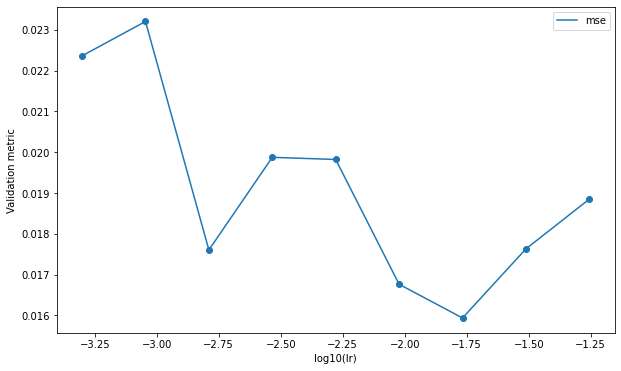

In [487]:
# Plot Loss vs point in grid search
data_out = "data_unconstrained_05ResidentialBuilding/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward02.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'], label='mse')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [509]:
# Display grid search results
data_out = "data_unconstrained_05ResidentialBuilding/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward02.csv'))

idx = df_grid_loss.valid_mse.idxmin()
best_lr_fward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_fward))
print("- Best valid mse = {}".format(best_mse))

# Copy best model to main directory
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/model05_forward02_"+str(idx+1)+"_best.pth", 
            "data_unconstrained_05ResidentialBuilding/model05_forward02_best.pth")
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/model05_forward02_"+str(idx+1)+"_last.pth", 
            "data_unconstrained_05ResidentialBuilding/model05_forward02_last.pth")
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/train_forward02_"+str(idx+1)+".csv", 
            "data_unconstrained_05ResidentialBuilding/train_loss02.csv")
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/valid_forward02_"+str(idx+1)+".csv", 
            "data_unconstrained_05ResidentialBuilding/valid_loss02.csv")

Best parameters (7):
- Best lr = 0.01710
- Best valid mse = 0.015937919


'data_unconstrained_05ResidentialBuilding/valid_loss02.csv'

In [484]:
# Grid search space
target_idx = 1
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_mse', 'valid_r2'], 
                            index=range(len(grid_lrs)))

In [486]:
# Perform grid search (Lockdown: path 2)
target_idx = 1
layer_sizes = [5, 1]
epochs = 20000
data_in = 'dataset_05ResidentialBuilding'
data_out = "data_lockdown_05ResidentialBuilding/lrs"
step = 1
lock_flag = True

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders(target_idx=target_idx)
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    model_forward_name = 'data_unconstrained_05ResidentialBuilding/lrs/model05_forward02_'+str(n)+'_last.pth'
    fname = 'model05_backward02_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss02_'+str(n)+'.csv', 
                'valid_loss02_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())

# .save grid search results
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], mse, r2]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_backward02.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00050
-Model saved after iteration 10346.
-Train.  Loss=0.0053261
-Valid.  Loss=0.0148894

Best train loss = 0.0050604

'train_loss02_1.csv' saved.
'valid_loss02_1.csv' saved.
'model05_backward02_1_best.pth' saved.



Summary:
-learning rate = 0.00090
-Model saved after iteration 14869.
-Train.  Loss=0.0061661
-Valid.  Loss=0.0152913

Best train loss = 0.0053701

'train_loss02_2.csv' saved.
'valid_loss02_2.csv' saved.
'model05_backward02_2_best.pth' saved.



Summary:
-learning rate = 0.00162
-Model saved after iteration 14950.
-Train.  Loss=0.0072858
-Valid.  Loss=0.0166679

Best train loss = 0.0039699

'train_loss02_3.csv' saved.
'valid_loss02_3.csv' saved.
'model05_backward02_3_best.pth' saved.



Summary:
-learning rate = 0.00292
-Model saved after iteration 17222.
-Train.  Loss=0.0117852
-Valid.  Loss=0.0143784

Best train loss = 0.0048616

'train_loss02_4.csv' saved.
'valid_loss02_4.csv' saved.
'model05_backward02_4_best.pth' saved.



Summary:
-learning rate = 0.00527
-Model saved after iteration 14667.
-Train.  Loss=0.0123654
-Valid.  Loss=0.0104609

Best train loss = 0.0023028

'train_loss02_5.csv' saved.
'valid_loss02_5.csv' saved.
'model05_backward02_5_best.pth' saved.



Summary:
-learning rate = 0.00949
-Model saved after iteration 18839.
-Train.  Loss=0.0229262
-Valid.  Loss=0.0210174

Best train loss = 0.0019533

'train_loss02_6.csv' saved.
'valid_loss02_6.csv' saved.
'model05_backward02_6_best.pth' saved.



Summary:
-learning rate = 0.01710
-Model saved after iteration 1.
-Train.  Loss=0.0016432
-Valid.  Loss=0.0160367

Best train loss = 0.0016432

'train_loss02_7.csv' saved.
'valid_loss02_7.csv' saved.
'model05_backward02_7_best.pth' saved.



Summary:
-learning rate = 0.03081
-Model saved after iteration 15636.
-Train.  Loss=0.0243536
-Valid.  Loss=0.0201892

Best train loss = 0.0023451

'train_loss02_8.csv' saved.
'valid_loss02_8.csv' saved.
'model05_backward02_8_best.pth' saved.



Summary:
-learning rate = 0.05550
-Model saved after iteration 1.
-Train.  Loss=0.0012393
-Valid.  Loss=0.0215009

Best train loss = 0.0012393

'train_loss02_9.csv' saved.
'valid_loss02_9.csv' saved.
'model05_backward02_9_best.pth' saved.



Summary:
-learning rate = 0.10000
-Model saved after iteration 1.
-Train.  Loss=nan
-Valid.  Loss=nan

Best train loss = nan

'train_loss02_10.csv' saved.
'valid_loss02_10.csv' saved.



FileNotFoundError: [Errno 2] No such file or directory: 'model05_backward02_10_best.pth'

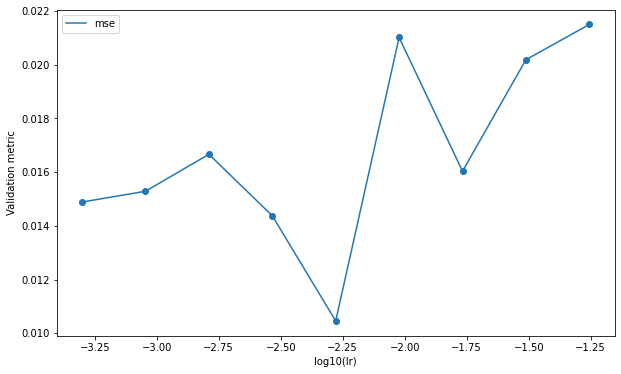

In [489]:
# Plot Loss vs point in grid search
data_out = "data_lockdown_05ResidentialBuilding/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward02.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'], label='mse')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [510]:
# Display grid search results
data_out = "data_lockdown_05ResidentialBuilding/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward02.csv'))

idx = df_grid_loss.valid_mse.idxmin()
best_lr_bward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_bward))
print("- Best valid mse = {}".format(best_mse))

# Copy best models to main directory
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/model05_forward02_"+str(idx+1)+"_best.pth", 
            "data_lockdown_05ResidentialBuilding/model05_fward02_best.pth")
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/model05_forward02_"+str(idx+1)+"_last.pth", 
            "data_lockdown_05ResidentialBuilding/model05_fward02_last.pth")
shutil.copy("data_lockdown_05ResidentialBuilding/lrs/model05_backward02_"+str(idx+1)+"_best.pth", 
            "data_lockdown_05ResidentialBuilding/model05_backward02_best.pth")

shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/train_forward02_"+str(idx+1)+".csv", 
            "data_lockdown_05ResidentialBuilding/train_loss_fward02.csv")
shutil.copy("data_unconstrained_05ResidentialBuilding/lrs/valid_forward02_"+str(idx+1)+".csv", 
            "data_lockdown_05ResidentialBuilding/valid_loss_fward02.csv")
shutil.copy("data_lockdown_05ResidentialBuilding/lrs/train_loss02_"+str(idx+1)+".csv", 
            "data_lockdown_05ResidentialBuilding/train_loss02.csv")
shutil.copy("data_lockdown_05ResidentialBuilding/lrs/valid_loss02_"+str(idx+1)+".csv", 
            "data_lockdown_05ResidentialBuilding/valid_loss02.csv")

Best parameters (5):
- Best lr = 0.00527
- Best valid mse = 0.010460922


'data_lockdown_05ResidentialBuilding/valid_loss02.csv'

In [494]:
# Find MSE, R2, etc...
target_idx = 1
data_out = "data_lockdown_05ResidentialBuilding"
index = pd.MultiIndex.from_product([['TRAIN', 'VALIDATION', 'TEST'], ['forward', 'lockdown']])
df_results = pd.DataFrame(index=index, columns=['MSE', 'R2'])

# Unconstrained results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_unconstrained_05ResidentialBuilding/model05_forward02_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
mse = mean_squared_error(ytrain[:,target_idx].detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytrain[:,target_idx].detach().numpy(), ypred.detach().numpy())
df_results.loc[('TRAIN', 'forward'), 'MSE'] = mse
df_results.loc[('TRAIN', 'forward'), 'R2'] = r2

ypred = mm(xvalid)
mse = mean_squared_error(yvalid[:,target_idx].detach().numpy(), ypred.detach().numpy())
r2 = r2_score(yvalid[:,target_idx].detach().numpy(), ypred.detach().numpy())
df_results.loc[('VALIDATION', 'forward'), 'MSE'] = mse
df_results.loc[('VALIDATION', 'forward'), 'R2'] = r2

ypred = mm(xtest)
mse = mean_squared_error(ytest[:,target_idx].detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytest[:,target_idx].detach().numpy(), ypred.detach().numpy())
df_results.loc[('TEST', 'forward'), 'MSE'] = mse
df_results.loc[('TEST', 'forward'), 'R2'] = r2

# Lockdown results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_lockdown_05ResidentialBuilding/model05_backward02_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
mse = mean_squared_error(ytrain[:,target_idx].detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytrain[:,target_idx].detach().numpy(), ypred.detach().numpy())
df_results.loc[('TRAIN', 'lockdown'), 'MSE'] = mse
df_results.loc[('TRAIN', 'lockdown'), 'R2'] = r2

ypred = mm(xvalid)
mse = mean_squared_error(yvalid[:,target_idx].detach().numpy(), ypred.detach().numpy())
r2 = r2_score(yvalid[:,target_idx].detach().numpy(), ypred.detach().numpy())
df_results.loc[('VALIDATION', 'lockdown'), 'MSE'] = mse
df_results.loc[('VALIDATION', 'lockdown'), 'R2'] = r2

ypred = mm(xtest)
mse = mean_squared_error(ytest[:,target_idx].detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytest[:,target_idx].detach().numpy(), ypred.detach().numpy())
df_results.loc[('TEST', 'lockdown'), 'MSE'] = mse
df_results.loc[('TEST', 'lockdown'), 'R2'] = r2

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_lockdown02.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_lockdown02.csv')))
df_results

model results saved at: 'data_lockdown_05ResidentialBuilding/results_target_lockdown02.csv'


MSE        R2
TRAIN      forward   0.00171397  0.998286
           lockdown   0.0123654  0.987635
VALIDATION forward    0.0159379  0.983051
           lockdown   0.0104609  0.988875
TEST       forward    0.0140404  0.988154
           lockdown   0.0184297   0.98445

In [498]:
# Find Accuracy, Loss +/- STD (Fordward)
target_idx = 1
data_output = 'data_unconstrained_05ResidentialBuilding'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])
# df_results = pd.read_csv(os.path.join(data_output, 'accuracy_forward01.csv'), index_col=0)

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_05ResidentialBuilding/X.csv')
    y = pd.read_csv('dataset_05ResidentialBuilding/y.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders(target_idx=target_idx)

# .train model (forward)
    lr = best_lr_fward
    layer_sizes = [5, 1]
    epochs = 50000
    data_out = "data_unconstrained_05ResidentialBuilding/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model05_forward02_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = 10000, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss02_'+str(n)+'.csv', 
                'valid_loss02_'+str(n)+'.csv', f3)

# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    mse = mean_squared_error(ytrain.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytrain.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'train_mse'] = mse
    df_results.loc[n, 'train_r2']  = r2

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'valid_mse'] = mse
    df_results.loc[n, 'valid_r2']  = r2

    ypred = mm(xtest)
    mse = mean_squared_error(ytest.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytest.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'test_mse'] = mse
    df_results.loc[n, 'test_r2']  = r2

    df_results.to_csv(os.path.join(data_output, 'accuracy05_forward02.csv'), index=True)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 466.
-Train.  Loss=0.0200648
-Valid.  Loss=0.0309345
'train_loss02_1.csv' saved.
'valid_loss02_1.csv' saved.
'model05_forward02_1_last.pth' saved.
'model05_forward02_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 16168.
-Train.  Loss=0.0026569
-Valid.  Loss=0.0093223
'train_loss02_2.csv' saved.
'valid_loss02_2.csv' saved.
'model05_forward02_2_last.pth' saved.
'model05_forward02_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5418.
-Train.  Loss=0.0044595
-Valid.  Loss=0.0389762
'train_loss02_3.csv' saved.
'valid_loss02_3.csv' saved.
'model05_forward02_3_last.pth' saved.
'model05_forward02_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 21349.
-Train.  Loss=0.0022262
-Valid.  Loss=0.0147848
'train_loss02_4.csv' saved.
'valid_loss02_4.csv' saved.
'model05_forward02_4_last.pth' saved.
'model05_forward02_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 18337.
-Train.  Loss=0.0025616
-Valid.  Loss=0.0734322
'train_loss02_5.csv' saved.
'valid_loss02_5.csv' saved.
'model05_forward02_5_last.pth' saved.
'model05_forward02_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1069.
-Train.  Loss=0.0110079
-Valid.  Loss=0.0468237
'train_loss02_6.csv' saved.
'valid_loss02_6.csv' saved.
'model05_forward02_6_last.pth' saved.
'model05_forward02_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 9649.
-Train.  Loss=0.0035011
-Valid.  Loss=0.0259279
'train_loss02_7.csv' saved.
'valid_loss02_7.csv' saved.
'model05_forward02_7_last.pth' saved.
'model05_forward02_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 124.
-Train.  Loss=0.0504731
-Valid.  Loss=0.1210086
'train_loss02_8.csv' saved.
'valid_loss02_8.csv' saved.
'model05_forward02_8_last.pth' saved.
'model05_forward02_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7317.
-Train.  Loss=0.0033587
-Valid.  Loss=0.0141755
'train_loss02_9.csv' saved.
'valid_loss02_9.csv' saved.
'model05_forward02_9_last.pth' saved.
'model05_forward02_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 856.
-Train.  Loss=0.0123045
-Valid.  Loss=0.0218229
'train_loss02_10.csv' saved.
'valid_loss02_10.csv' saved.
'model05_forward02_10_last.pth' saved.
'model05_forward02_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 39012.
-Train.  Loss=0.0027019
-Valid.  Loss=0.0198209
'train_loss02_11.csv' saved.
'valid_loss02_11.csv' saved.
'model05_forward02_11_last.pth' saved.
'model05_forward02_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 31864.
-Train.  Loss=0.0040747
-Valid.  Loss=0.0158342
'train_loss02_12.csv' saved.
'valid_loss02_12.csv' saved.
'model05_forward02_12_last.pth' saved.
'model05_forward02_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 9815.
-Train.  Loss=0.0164553
-Valid.  Loss=0.0222445
'train_loss02_13.csv' saved.
'valid_loss02_13.csv' saved.
'model05_forward02_13_last.pth' saved.
'model05_forward02_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 13919.
-Train.  Loss=0.0036803
-Valid.  Loss=0.0194697
'train_loss02_14.csv' saved.
'valid_loss02_14.csv' saved.
'model05_forward02_14_last.pth' saved.
'model05_forward02_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6504.
-Train.  Loss=0.0046436
-Valid.  Loss=0.0198014
'train_loss02_15.csv' saved.
'valid_loss02_15.csv' saved.
'model05_forward02_15_last.pth' saved.
'model05_forward02_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 463.
-Train.  Loss=0.0170423
-Valid.  Loss=0.0826198
'train_loss02_16.csv' saved.
'valid_loss02_16.csv' saved.
'model05_forward02_16_last.pth' saved.
'model05_forward02_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10417.
-Train.  Loss=0.0039347
-Valid.  Loss=0.0090934
'train_loss02_17.csv' saved.
'valid_loss02_17.csv' saved.
'model05_forward02_17_last.pth' saved.
'model05_forward02_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 8366.
-Train.  Loss=0.0032626
-Valid.  Loss=0.0142520
'train_loss02_18.csv' saved.
'valid_loss02_18.csv' saved.
'model05_forward02_18_last.pth' saved.
'model05_forward02_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 16273.
-Train.  Loss=0.0043823
-Valid.  Loss=0.0625673
'train_loss02_19.csv' saved.
'valid_loss02_19.csv' saved.
'model05_forward02_19_last.pth' saved.
'model05_forward02_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5307.
-Train.  Loss=0.0046495
-Valid.  Loss=0.0115730
'train_loss02_20.csv' saved.
'valid_loss02_20.csv' saved.
'model05_forward02_20_last.pth' saved.
'model05_forward02_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 14453.
-Train.  Loss=0.0029850
-Valid.  Loss=0.0364759
'train_loss02_21.csv' saved.
'valid_loss02_21.csv' saved.
'model05_forward02_21_last.pth' saved.
'model05_forward02_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 479.
-Train.  Loss=0.0172056
-Valid.  Loss=0.0241743
'train_loss02_22.csv' saved.
'valid_loss02_22.csv' saved.
'model05_forward02_22_last.pth' saved.
'model05_forward02_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 38448.
-Train.  Loss=0.0021374
-Valid.  Loss=0.0187398
'train_loss02_23.csv' saved.
'valid_loss02_23.csv' saved.
'model05_forward02_23_last.pth' saved.
'model05_forward02_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 31288.
-Train.  Loss=0.0024740
-Valid.  Loss=0.0235820
'train_loss02_24.csv' saved.
'valid_loss02_24.csv' saved.
'model05_forward02_24_last.pth' saved.
'model05_forward02_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 14923.
-Train.  Loss=0.0022949
-Valid.  Loss=0.0314603
'train_loss02_25.csv' saved.
'valid_loss02_25.csv' saved.
'model05_forward02_25_last.pth' saved.
'model05_forward02_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2187.
-Train.  Loss=0.0103686
-Valid.  Loss=0.0149824
'train_loss02_26.csv' saved.
'valid_loss02_26.csv' saved.
'model05_forward02_26_last.pth' saved.
'model05_forward02_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7234.
-Train.  Loss=0.0042571
-Valid.  Loss=0.0471817
'train_loss02_27.csv' saved.
'valid_loss02_27.csv' saved.
'model05_forward02_27_last.pth' saved.
'model05_forward02_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 25515.
-Train.  Loss=0.0024253
-Valid.  Loss=0.0140135
'train_loss02_28.csv' saved.
'valid_loss02_28.csv' saved.
'model05_forward02_28_last.pth' saved.
'model05_forward02_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 241.
-Train.  Loss=0.0306680
-Valid.  Loss=0.0241505
'train_loss02_29.csv' saved.
'valid_loss02_29.csv' saved.
'model05_forward02_29_last.pth' saved.
'model05_forward02_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4909.
-Train.  Loss=0.0068390
-Valid.  Loss=0.0262887
'train_loss02_30.csv' saved.
'valid_loss02_30.csv' saved.
'model05_forward02_30_last.pth' saved.
'model05_forward02_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2932.
-Train.  Loss=0.0101163
-Valid.  Loss=0.0248854
'train_loss02_31.csv' saved.
'valid_loss02_31.csv' saved.
'model05_forward02_31_last.pth' saved.
'model05_forward02_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1718.
-Train.  Loss=0.0095525
-Valid.  Loss=0.0284137
'train_loss02_32.csv' saved.
'valid_loss02_32.csv' saved.
'model05_forward02_32_last.pth' saved.
'model05_forward02_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3337.
-Train.  Loss=0.0063893
-Valid.  Loss=0.0168906
'train_loss02_33.csv' saved.
'valid_loss02_33.csv' saved.
'model05_forward02_33_last.pth' saved.
'model05_forward02_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 9594.
-Train.  Loss=0.0092124
-Valid.  Loss=0.3023967
'train_loss02_34.csv' saved.
'valid_loss02_34.csv' saved.
'model05_forward02_34_last.pth' saved.
'model05_forward02_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 48060.
-Train.  Loss=0.0016596
-Valid.  Loss=0.0332984
'train_loss02_35.csv' saved.
'valid_loss02_35.csv' saved.
'model05_forward02_35_last.pth' saved.
'model05_forward02_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 49985.
-Train.  Loss=0.0028450
-Valid.  Loss=0.0119919
'train_loss02_36.csv' saved.
'valid_loss02_36.csv' saved.
'model05_forward02_36_last.pth' saved.
'model05_forward02_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 16854.
-Train.  Loss=0.0042006
-Valid.  Loss=0.0092144
'train_loss02_37.csv' saved.
'valid_loss02_37.csv' saved.
'model05_forward02_37_last.pth' saved.
'model05_forward02_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1795.
-Train.  Loss=0.0065783
-Valid.  Loss=0.0135063
'train_loss02_38.csv' saved.
'valid_loss02_38.csv' saved.
'model05_forward02_38_last.pth' saved.
'model05_forward02_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 47258.
-Train.  Loss=0.0042926
-Valid.  Loss=0.0272467
'train_loss02_39.csv' saved.
'valid_loss02_39.csv' saved.
'model05_forward02_39_last.pth' saved.
'model05_forward02_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 50000.
-Train.  Loss=0.0018845
-Valid.  Loss=0.0360528
'train_loss02_40.csv' saved.
'valid_loss02_40.csv' saved.
'model05_forward02_40_last.pth' saved.
'model05_forward02_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6349.
-Train.  Loss=0.0045133
-Valid.  Loss=0.0150183
'train_loss02_41.csv' saved.
'valid_loss02_41.csv' saved.
'model05_forward02_41_last.pth' saved.
'model05_forward02_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 8358.
-Train.  Loss=0.0041304
-Valid.  Loss=0.0139420
'train_loss02_42.csv' saved.
'valid_loss02_42.csv' saved.
'model05_forward02_42_last.pth' saved.
'model05_forward02_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6560.
-Train.  Loss=0.0047146
-Valid.  Loss=0.0165545
'train_loss02_43.csv' saved.
'valid_loss02_43.csv' saved.
'model05_forward02_43_last.pth' saved.
'model05_forward02_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 527.
-Train.  Loss=0.0200810
-Valid.  Loss=0.0301655
'train_loss02_44.csv' saved.
'valid_loss02_44.csv' saved.
'model05_forward02_44_last.pth' saved.
'model05_forward02_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3522.
-Train.  Loss=0.0163850
-Valid.  Loss=0.0186235
'train_loss02_45.csv' saved.
'valid_loss02_45.csv' saved.
'model05_forward02_45_last.pth' saved.
'model05_forward02_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 23172.
-Train.  Loss=0.0026538
-Valid.  Loss=0.0095982
'train_loss02_46.csv' saved.
'valid_loss02_46.csv' saved.
'model05_forward02_46_last.pth' saved.
'model05_forward02_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6304.
-Train.  Loss=0.0043208
-Valid.  Loss=0.0164008
'train_loss02_47.csv' saved.
'valid_loss02_47.csv' saved.
'model05_forward02_47_last.pth' saved.
'model05_forward02_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 49964.
-Train.  Loss=0.0017861
-Valid.  Loss=0.0125749
'train_loss02_48.csv' saved.
'valid_loss02_48.csv' saved.
'model05_forward02_48_last.pth' saved.
'model05_forward02_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1805.
-Train.  Loss=0.0083808
-Valid.  Loss=0.0265327
'train_loss02_49.csv' saved.
'valid_loss02_49.csv' saved.
'model05_forward02_49_last.pth' saved.
'model05_forward02_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10954.
-Train.  Loss=0.0036007
-Valid.  Loss=0.0253251
'train_loss02_50.csv' saved.
'valid_loss02_50.csv' saved.
'model05_forward02_50_last.pth' saved.
'model05_forward02_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1971.
-Train.  Loss=0.0096077
-Valid.  Loss=0.0136039
'train_loss02_51.csv' saved.
'valid_loss02_51.csv' saved.
'model05_forward02_51_last.pth' saved.
'model05_forward02_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 712.
-Train.  Loss=0.0151005
-Valid.  Loss=0.0400290
'train_loss02_52.csv' saved.
'valid_loss02_52.csv' saved.
'model05_forward02_52_last.pth' saved.
'model05_forward02_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 46274.
-Train.  Loss=0.0022242
-Valid.  Loss=0.0553154
'train_loss02_53.csv' saved.
'valid_loss02_53.csv' saved.
'model05_forward02_53_last.pth' saved.
'model05_forward02_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2773.
-Train.  Loss=0.0061479
-Valid.  Loss=0.0142945
'train_loss02_54.csv' saved.
'valid_loss02_54.csv' saved.
'model05_forward02_54_last.pth' saved.
'model05_forward02_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10344.
-Train.  Loss=0.0045665
-Valid.  Loss=0.0317087
'train_loss02_55.csv' saved.
'valid_loss02_55.csv' saved.
'model05_forward02_55_last.pth' saved.
'model05_forward02_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 18484.
-Train.  Loss=0.0020906
-Valid.  Loss=0.0354584
'train_loss02_56.csv' saved.
'valid_loss02_56.csv' saved.
'model05_forward02_56_last.pth' saved.
'model05_forward02_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1577.
-Train.  Loss=0.0063305
-Valid.  Loss=0.0416567
'train_loss02_57.csv' saved.
'valid_loss02_57.csv' saved.
'model05_forward02_57_last.pth' saved.
'model05_forward02_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6564.
-Train.  Loss=0.0038736
-Valid.  Loss=0.0076333
'train_loss02_58.csv' saved.
'valid_loss02_58.csv' saved.
'model05_forward02_58_last.pth' saved.
'model05_forward02_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6277.
-Train.  Loss=0.0048333
-Valid.  Loss=0.0169603
'train_loss02_59.csv' saved.
'valid_loss02_59.csv' saved.
'model05_forward02_59_last.pth' saved.
'model05_forward02_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 16429.
-Train.  Loss=0.0036175
-Valid.  Loss=0.0170292
'train_loss02_60.csv' saved.
'valid_loss02_60.csv' saved.
'model05_forward02_60_last.pth' saved.
'model05_forward02_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3468.
-Train.  Loss=0.0057978
-Valid.  Loss=0.0093484
'train_loss02_61.csv' saved.
'valid_loss02_61.csv' saved.
'model05_forward02_61_last.pth' saved.
'model05_forward02_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 28255.
-Train.  Loss=0.0028968
-Valid.  Loss=0.0433757
'train_loss02_62.csv' saved.
'valid_loss02_62.csv' saved.
'model05_forward02_62_last.pth' saved.
'model05_forward02_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 26559.
-Train.  Loss=0.0027617
-Valid.  Loss=0.0194717
'train_loss02_63.csv' saved.
'valid_loss02_63.csv' saved.
'model05_forward02_63_last.pth' saved.
'model05_forward02_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 14561.
-Train.  Loss=0.0026454
-Valid.  Loss=0.0202425
'train_loss02_64.csv' saved.
'valid_loss02_64.csv' saved.
'model05_forward02_64_last.pth' saved.
'model05_forward02_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 33383.
-Train.  Loss=0.0020388
-Valid.  Loss=0.0140432
'train_loss02_65.csv' saved.
'valid_loss02_65.csv' saved.
'model05_forward02_65_last.pth' saved.
'model05_forward02_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 16321.
-Train.  Loss=0.0029192
-Valid.  Loss=0.0196424
'train_loss02_66.csv' saved.
'valid_loss02_66.csv' saved.
'model05_forward02_66_last.pth' saved.
'model05_forward02_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 13199.
-Train.  Loss=0.0033978
-Valid.  Loss=0.0459346
'train_loss02_67.csv' saved.
'valid_loss02_67.csv' saved.
'model05_forward02_67_last.pth' saved.
'model05_forward02_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 14266.
-Train.  Loss=0.0037967
-Valid.  Loss=0.0119206
'train_loss02_68.csv' saved.
'valid_loss02_68.csv' saved.
'model05_forward02_68_last.pth' saved.
'model05_forward02_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1409.
-Train.  Loss=0.0081617
-Valid.  Loss=0.0188034
'train_loss02_69.csv' saved.
'valid_loss02_69.csv' saved.
'model05_forward02_69_last.pth' saved.
'model05_forward02_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10217.
-Train.  Loss=0.0030951
-Valid.  Loss=0.0287730
'train_loss02_70.csv' saved.
'valid_loss02_70.csv' saved.
'model05_forward02_70_last.pth' saved.
'model05_forward02_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 612.
-Train.  Loss=0.0191796
-Valid.  Loss=0.0291099
'train_loss02_71.csv' saved.
'valid_loss02_71.csv' saved.
'model05_forward02_71_last.pth' saved.
'model05_forward02_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1583.
-Train.  Loss=0.0110233
-Valid.  Loss=0.0294252
'train_loss02_72.csv' saved.
'valid_loss02_72.csv' saved.
'model05_forward02_72_last.pth' saved.
'model05_forward02_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6279.
-Train.  Loss=0.0042964
-Valid.  Loss=0.0353624
'train_loss02_73.csv' saved.
'valid_loss02_73.csv' saved.
'model05_forward02_73_last.pth' saved.
'model05_forward02_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4382.
-Train.  Loss=0.0036748
-Valid.  Loss=0.0283328
'train_loss02_74.csv' saved.
'valid_loss02_74.csv' saved.
'model05_forward02_74_last.pth' saved.
'model05_forward02_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2685.
-Train.  Loss=0.0058206
-Valid.  Loss=0.0184369
'train_loss02_75.csv' saved.
'valid_loss02_75.csv' saved.
'model05_forward02_75_last.pth' saved.
'model05_forward02_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4166.
-Train.  Loss=0.0095431
-Valid.  Loss=0.0221968
'train_loss02_76.csv' saved.
'valid_loss02_76.csv' saved.
'model05_forward02_76_last.pth' saved.
'model05_forward02_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10773.
-Train.  Loss=0.0040954
-Valid.  Loss=0.0124907
'train_loss02_77.csv' saved.
'valid_loss02_77.csv' saved.
'model05_forward02_77_last.pth' saved.
'model05_forward02_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2678.
-Train.  Loss=0.0075884
-Valid.  Loss=0.0180466
'train_loss02_78.csv' saved.
'valid_loss02_78.csv' saved.
'model05_forward02_78_last.pth' saved.
'model05_forward02_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2486.
-Train.  Loss=0.0056657
-Valid.  Loss=0.0327152
'train_loss02_79.csv' saved.
'valid_loss02_79.csv' saved.
'model05_forward02_79_last.pth' saved.
'model05_forward02_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6180.
-Train.  Loss=0.0040965
-Valid.  Loss=0.0168223
'train_loss02_80.csv' saved.
'valid_loss02_80.csv' saved.
'model05_forward02_80_last.pth' saved.
'model05_forward02_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 481.
-Train.  Loss=0.0195007
-Valid.  Loss=0.0491629
'train_loss02_81.csv' saved.
'valid_loss02_81.csv' saved.
'model05_forward02_81_last.pth' saved.
'model05_forward02_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 978.
-Train.  Loss=0.0082307
-Valid.  Loss=0.0400116
'train_loss02_82.csv' saved.
'valid_loss02_82.csv' saved.
'model05_forward02_82_last.pth' saved.
'model05_forward02_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 39706.
-Train.  Loss=0.0015525
-Valid.  Loss=0.0204203
'train_loss02_83.csv' saved.
'valid_loss02_83.csv' saved.
'model05_forward02_83_last.pth' saved.
'model05_forward02_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5604.
-Train.  Loss=0.0058462
-Valid.  Loss=0.0294196
'train_loss02_84.csv' saved.
'valid_loss02_84.csv' saved.
'model05_forward02_84_last.pth' saved.
'model05_forward02_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2455.
-Train.  Loss=0.0074720
-Valid.  Loss=0.0643387
'train_loss02_85.csv' saved.
'valid_loss02_85.csv' saved.
'model05_forward02_85_last.pth' saved.
'model05_forward02_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 152.
-Train.  Loss=0.0471328
-Valid.  Loss=0.0634024
'train_loss02_86.csv' saved.
'valid_loss02_86.csv' saved.
'model05_forward02_86_last.pth' saved.
'model05_forward02_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 27124.
-Train.  Loss=0.0029295
-Valid.  Loss=0.0166411
'train_loss02_87.csv' saved.
'valid_loss02_87.csv' saved.
'model05_forward02_87_last.pth' saved.
'model05_forward02_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 41382.
-Train.  Loss=0.0026617
-Valid.  Loss=0.0310084
'train_loss02_88.csv' saved.
'valid_loss02_88.csv' saved.
'model05_forward02_88_last.pth' saved.
'model05_forward02_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 26393.
-Train.  Loss=0.0024332
-Valid.  Loss=0.0326916
'train_loss02_89.csv' saved.
'valid_loss02_89.csv' saved.
'model05_forward02_89_last.pth' saved.
'model05_forward02_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 70.
-Train.  Loss=0.0713440
-Valid.  Loss=0.1018200
'train_loss02_90.csv' saved.
'valid_loss02_90.csv' saved.
'model05_forward02_90_last.pth' saved.
'model05_forward02_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1894.
-Train.  Loss=0.0070666
-Valid.  Loss=0.0301047
'train_loss02_91.csv' saved.
'valid_loss02_91.csv' saved.
'model05_forward02_91_last.pth' saved.
'model05_forward02_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 31785.
-Train.  Loss=0.0031055
-Valid.  Loss=0.0188605
'train_loss02_92.csv' saved.
'valid_loss02_92.csv' saved.
'model05_forward02_92_last.pth' saved.
'model05_forward02_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2769.
-Train.  Loss=0.0076320
-Valid.  Loss=0.0180093
'train_loss02_93.csv' saved.
'valid_loss02_93.csv' saved.
'model05_forward02_93_last.pth' saved.
'model05_forward02_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 24823.
-Train.  Loss=0.0019827
-Valid.  Loss=0.0747182
'train_loss02_94.csv' saved.
'valid_loss02_94.csv' saved.
'model05_forward02_94_last.pth' saved.
'model05_forward02_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 39570.
-Train.  Loss=0.0027423
-Valid.  Loss=0.0153281
'train_loss02_95.csv' saved.
'valid_loss02_95.csv' saved.
'model05_forward02_95_last.pth' saved.
'model05_forward02_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5074.
-Train.  Loss=0.0048748
-Valid.  Loss=0.0425640
'train_loss02_96.csv' saved.
'valid_loss02_96.csv' saved.
'model05_forward02_96_last.pth' saved.
'model05_forward02_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5757.
-Train.  Loss=0.0060389
-Valid.  Loss=0.0229076
'train_loss02_97.csv' saved.
'valid_loss02_97.csv' saved.
'model05_forward02_97_last.pth' saved.
'model05_forward02_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 158.
-Train.  Loss=0.0339897
-Valid.  Loss=0.0431540
'train_loss02_98.csv' saved.
'valid_loss02_98.csv' saved.
'model05_forward02_98_last.pth' saved.
'model05_forward02_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 23013.
-Train.  Loss=0.0022231
-Valid.  Loss=0.0190123
'train_loss02_99.csv' saved.
'valid_loss02_99.csv' saved.
'model05_forward02_99_last.pth' saved.
'model05_forward02_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 16771.
-Train.  Loss=0.0025824
-Valid.  Loss=0.0217753
'train_loss02_100.csv' saved.
'valid_loss02_100.csv' saved.
'model05_forward02_100_last.pth' saved.
'model05_forward02_100_best.pth' saved.



In [499]:
# Display results
data_out = 'data_unconstrained_05ResidentialBuilding'
accuracy = pd.read_csv(os.path.join(data_out, 'accuracy05_forward02.csv'))
print("Train mse = {:.5f} +/- {:.5f}".format(accuracy['train_mse'].mean(), 
                                             accuracy['train_mse'].std()))
print("Valid mse = {:.5f} +/- {:.5f}".format(accuracy['valid_mse'].mean(), 
                                             accuracy['valid_mse'].std()))
print("Test mse = {:.5f} +/- {:.5f}".format(accuracy['test_mse'].mean(), 
                                            accuracy['test_mse'].std()))

print("")
print("Train r2 = {:.5f} +/- {:.5f}".format(accuracy['train_r2'].mean(), 
                                            accuracy['train_r2'].std()))
print("Valid r2 = {:.5f} +/- {:.5f}".format(accuracy['valid_r2'].mean(), 
                                            accuracy['valid_r2'].std()))
print("Test r2 = {:.5f} +/- {:.5f}".format(accuracy['test_r2'].mean(), 
                                           accuracy['test_r2'].std()))

Train mse = 0.00799 +/- 0.01051
Valid mse = 0.03128 +/- 0.03354
Test mse = 0.03670 +/- 0.03014

Train r2 = 0.99201 +/- 0.01051
Valid r2 = 0.97030 +/- 0.02495
Test r2 = 0.96438 +/- 0.02479


In [501]:
# Find Accuracy, Loss +/- STD (Lockdown: path 1)
target_idx = 1
data_output = 'data_lockdown_05ResidentialBuilding'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])
# df_results = pd.read_csv(os.path.join(data_output, 'accuracy_forward01.csv'), index_col=0)

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_05ResidentialBuilding/X.csv')
    y = pd.read_csv('dataset_05ResidentialBuilding/y.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders(target_idx=target_idx)

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 1]
    epochs = 30000
    data_out = "data_lockdown_05ResidentialBuilding/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model05_forward02_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss02_'+str(n)+'.csv', 
                'valid_loss02_'+str(n)+'.csv', f3)

# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    mse = mean_squared_error(ytrain.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytrain.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'train_mse'] = mse
    df_results.loc[n, 'train_r2']  = r2

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'valid_mse'] = mse
    df_results.loc[n, 'valid_r2']  = r2

    ypred = mm(xtest)
    mse = mean_squared_error(ytest.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytest.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'test_mse'] = mse
    df_results.loc[n, 'test_r2']  = r2

    df_results.to_csv(os.path.join(data_output, 'accuracy05_fward02.csv'), index=True)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29998.
-Train.  Loss=0.0041718
-Valid.  Loss=0.0246561
'train_loss02_1.csv' saved.
'valid_loss02_1.csv' saved.
'model05_forward02_1_last.pth' saved.
'model05_forward02_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1420.
-Train.  Loss=0.0223500
-Valid.  Loss=0.0433167
'train_loss02_2.csv' saved.
'valid_loss02_2.csv' saved.
'model05_forward02_2_last.pth' saved.
'model05_forward02_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0036597
-Valid.  Loss=0.0237977
'train_loss02_3.csv' saved.
'valid_loss02_3.csv' saved.
'model05_forward02_3_last.pth' saved.
'model05_forward02_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13228.
-Train.  Loss=0.0040475
-Valid.  Loss=0.0124379
'train_loss02_4.csv' saved.
'valid_loss02_4.csv' saved.
'model05_forward02_4_last.pth' saved.
'model05_forward02_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29999.
-Train.  Loss=0.0034463
-Valid.  Loss=0.0720354
'train_loss02_5.csv' saved.
'valid_loss02_5.csv' saved.
'model05_forward02_5_last.pth' saved.
'model05_forward02_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1794.
-Train.  Loss=0.0193863
-Valid.  Loss=0.0712379
'train_loss02_6.csv' saved.
'valid_loss02_6.csv' saved.
'model05_forward02_6_last.pth' saved.
'model05_forward02_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14474.
-Train.  Loss=0.0065179
-Valid.  Loss=0.0217694
'train_loss02_7.csv' saved.
'valid_loss02_7.csv' saved.
'model05_forward02_7_last.pth' saved.
'model05_forward02_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 866.
-Train.  Loss=0.0221129
-Valid.  Loss=0.0555488
'train_loss02_8.csv' saved.
'valid_loss02_8.csv' saved.
'model05_forward02_8_last.pth' saved.
'model05_forward02_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29999.
-Train.  Loss=0.0036587
-Valid.  Loss=0.0152928
'train_loss02_9.csv' saved.
'valid_loss02_9.csv' saved.
'model05_forward02_9_last.pth' saved.
'model05_forward02_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4342.
-Train.  Loss=0.0496842
-Valid.  Loss=0.0196033
'train_loss02_10.csv' saved.
'valid_loss02_10.csv' saved.
'model05_forward02_10_last.pth' saved.
'model05_forward02_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13223.
-Train.  Loss=0.0049537
-Valid.  Loss=0.0275531
'train_loss02_11.csv' saved.
'valid_loss02_11.csv' saved.
'model05_forward02_11_last.pth' saved.
'model05_forward02_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 24635.
-Train.  Loss=0.0068445
-Valid.  Loss=0.0145469
'train_loss02_12.csv' saved.
'valid_loss02_12.csv' saved.
'model05_forward02_12_last.pth' saved.
'model05_forward02_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 9593.
-Train.  Loss=0.0071902
-Valid.  Loss=0.0132549
'train_loss02_13.csv' saved.
'valid_loss02_13.csv' saved.
'model05_forward02_13_last.pth' saved.
'model05_forward02_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11016.
-Train.  Loss=0.0058509
-Valid.  Loss=0.0188634
'train_loss02_14.csv' saved.
'valid_loss02_14.csv' saved.
'model05_forward02_14_last.pth' saved.
'model05_forward02_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 20615.
-Train.  Loss=0.0064651
-Valid.  Loss=0.0259341
'train_loss02_15.csv' saved.
'valid_loss02_15.csv' saved.
'model05_forward02_15_last.pth' saved.
'model05_forward02_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 893.
-Train.  Loss=0.0286454
-Valid.  Loss=0.0991660
'train_loss02_16.csv' saved.
'valid_loss02_16.csv' saved.
'model05_forward02_16_last.pth' saved.
'model05_forward02_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29988.
-Train.  Loss=0.0041828
-Valid.  Loss=0.0072585
'train_loss02_17.csv' saved.
'valid_loss02_17.csv' saved.
'model05_forward02_17_last.pth' saved.
'model05_forward02_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29960.
-Train.  Loss=0.0036150
-Valid.  Loss=0.0162936
'train_loss02_18.csv' saved.
'valid_loss02_18.csv' saved.
'model05_forward02_18_last.pth' saved.
'model05_forward02_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0038512
-Valid.  Loss=0.0650223
'train_loss02_19.csv' saved.
'valid_loss02_19.csv' saved.
'model05_forward02_19_last.pth' saved.
'model05_forward02_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29917.
-Train.  Loss=0.0112410
-Valid.  Loss=0.0163528
'train_loss02_20.csv' saved.
'valid_loss02_20.csv' saved.
'model05_forward02_20_last.pth' saved.
'model05_forward02_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29984.
-Train.  Loss=0.0041294
-Valid.  Loss=0.0410262
'train_loss02_21.csv' saved.
'valid_loss02_21.csv' saved.
'model05_forward02_21_last.pth' saved.
'model05_forward02_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 680.
-Train.  Loss=0.0274187
-Valid.  Loss=0.0402777
'train_loss02_22.csv' saved.
'valid_loss02_22.csv' saved.
'model05_forward02_22_last.pth' saved.
'model05_forward02_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1558.
-Train.  Loss=0.0173610
-Valid.  Loss=0.0197639
'train_loss02_23.csv' saved.
'valid_loss02_23.csv' saved.
'model05_forward02_23_last.pth' saved.
'model05_forward02_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29996.
-Train.  Loss=0.0036941
-Valid.  Loss=0.0235975
'train_loss02_24.csv' saved.
'valid_loss02_24.csv' saved.
'model05_forward02_24_last.pth' saved.
'model05_forward02_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2740.
-Train.  Loss=0.0102735
-Valid.  Loss=0.0611873
'train_loss02_25.csv' saved.
'valid_loss02_25.csv' saved.
'model05_forward02_25_last.pth' saved.
'model05_forward02_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 5680.
-Train.  Loss=0.0091131
-Valid.  Loss=0.0111100
'train_loss02_26.csv' saved.
'valid_loss02_26.csv' saved.
'model05_forward02_26_last.pth' saved.
'model05_forward02_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29999.
-Train.  Loss=0.0037281
-Valid.  Loss=0.0333550
'train_loss02_27.csv' saved.
'valid_loss02_27.csv' saved.
'model05_forward02_27_last.pth' saved.
'model05_forward02_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 22419.
-Train.  Loss=0.0059129
-Valid.  Loss=0.0180122
'train_loss02_28.csv' saved.
'valid_loss02_28.csv' saved.
'model05_forward02_28_last.pth' saved.
'model05_forward02_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1136.
-Train.  Loss=0.0297552
-Valid.  Loss=0.0427636
'train_loss02_29.csv' saved.
'valid_loss02_29.csv' saved.
'model05_forward02_29_last.pth' saved.
'model05_forward02_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29996.
-Train.  Loss=0.0036062
-Valid.  Loss=0.0201526
'train_loss02_30.csv' saved.
'valid_loss02_30.csv' saved.
'model05_forward02_30_last.pth' saved.
'model05_forward02_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12911.
-Train.  Loss=0.0062496
-Valid.  Loss=0.0165543
'train_loss02_31.csv' saved.
'valid_loss02_31.csv' saved.
'model05_forward02_31_last.pth' saved.
'model05_forward02_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0039323
-Valid.  Loss=0.0351497
'train_loss02_32.csv' saved.
'valid_loss02_32.csv' saved.
'model05_forward02_32_last.pth' saved.
'model05_forward02_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8978.
-Train.  Loss=0.0058143
-Valid.  Loss=0.0137920
'train_loss02_33.csv' saved.
'valid_loss02_33.csv' saved.
'model05_forward02_33_last.pth' saved.
'model05_forward02_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4335.
-Train.  Loss=0.0111653
-Valid.  Loss=0.0457174
'train_loss02_34.csv' saved.
'valid_loss02_34.csv' saved.
'model05_forward02_34_last.pth' saved.
'model05_forward02_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 25684.
-Train.  Loss=0.0032853
-Valid.  Loss=0.0374400
'train_loss02_35.csv' saved.
'valid_loss02_35.csv' saved.
'model05_forward02_35_last.pth' saved.
'model05_forward02_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29996.
-Train.  Loss=0.0038444
-Valid.  Loss=0.0118834
'train_loss02_36.csv' saved.
'valid_loss02_36.csv' saved.
'model05_forward02_36_last.pth' saved.
'model05_forward02_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 19039.
-Train.  Loss=0.0046503
-Valid.  Loss=0.0174445
'train_loss02_37.csv' saved.
'valid_loss02_37.csv' saved.
'model05_forward02_37_last.pth' saved.
'model05_forward02_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11124.
-Train.  Loss=0.0060786
-Valid.  Loss=0.0136990
'train_loss02_38.csv' saved.
'valid_loss02_38.csv' saved.
'model05_forward02_38_last.pth' saved.
'model05_forward02_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4314.
-Train.  Loss=0.0106745
-Valid.  Loss=0.0445053
'train_loss02_39.csv' saved.
'valid_loss02_39.csv' saved.
'model05_forward02_39_last.pth' saved.
'model05_forward02_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17338.
-Train.  Loss=0.0036967
-Valid.  Loss=0.0840954
'train_loss02_40.csv' saved.
'valid_loss02_40.csv' saved.
'model05_forward02_40_last.pth' saved.
'model05_forward02_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29999.
-Train.  Loss=0.0052532
-Valid.  Loss=0.0147558
'train_loss02_41.csv' saved.
'valid_loss02_41.csv' saved.
'model05_forward02_41_last.pth' saved.
'model05_forward02_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 21471.
-Train.  Loss=0.0056099
-Valid.  Loss=0.0171654
'train_loss02_42.csv' saved.
'valid_loss02_42.csv' saved.
'model05_forward02_42_last.pth' saved.
'model05_forward02_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29990.
-Train.  Loss=0.0037471
-Valid.  Loss=0.0199349
'train_loss02_43.csv' saved.
'valid_loss02_43.csv' saved.
'model05_forward02_43_last.pth' saved.
'model05_forward02_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2223.
-Train.  Loss=0.0165526
-Valid.  Loss=0.0388472
'train_loss02_44.csv' saved.
'valid_loss02_44.csv' saved.
'model05_forward02_44_last.pth' saved.
'model05_forward02_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10692.
-Train.  Loss=0.0057772
-Valid.  Loss=0.0142745
'train_loss02_45.csv' saved.
'valid_loss02_45.csv' saved.
'model05_forward02_45_last.pth' saved.
'model05_forward02_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29995.
-Train.  Loss=0.0029981
-Valid.  Loss=0.0108251
'train_loss02_46.csv' saved.
'valid_loss02_46.csv' saved.
'model05_forward02_46_last.pth' saved.
'model05_forward02_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 7648.
-Train.  Loss=0.0064061
-Valid.  Loss=0.0162708
'train_loss02_47.csv' saved.
'valid_loss02_47.csv' saved.
'model05_forward02_47_last.pth' saved.
'model05_forward02_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29993.
-Train.  Loss=0.0041199
-Valid.  Loss=0.0147360
'train_loss02_48.csv' saved.
'valid_loss02_48.csv' saved.
'model05_forward02_48_last.pth' saved.
'model05_forward02_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 7246.
-Train.  Loss=0.0060649
-Valid.  Loss=0.0268907
'train_loss02_49.csv' saved.
'valid_loss02_49.csv' saved.
'model05_forward02_49_last.pth' saved.
'model05_forward02_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0030709
-Valid.  Loss=0.0234504
'train_loss02_50.csv' saved.
'valid_loss02_50.csv' saved.
'model05_forward02_50_last.pth' saved.
'model05_forward02_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8461.
-Train.  Loss=0.0073163
-Valid.  Loss=0.0147336
'train_loss02_51.csv' saved.
'valid_loss02_51.csv' saved.
'model05_forward02_51_last.pth' saved.
'model05_forward02_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10859.
-Train.  Loss=0.0058028
-Valid.  Loss=0.0277005
'train_loss02_52.csv' saved.
'valid_loss02_52.csv' saved.
'model05_forward02_52_last.pth' saved.
'model05_forward02_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 25567.
-Train.  Loss=0.0052266
-Valid.  Loss=0.0891094
'train_loss02_53.csv' saved.
'valid_loss02_53.csv' saved.
'model05_forward02_53_last.pth' saved.
'model05_forward02_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29998.
-Train.  Loss=0.0029535
-Valid.  Loss=0.0127996
'train_loss02_54.csv' saved.
'valid_loss02_54.csv' saved.
'model05_forward02_54_last.pth' saved.
'model05_forward02_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0043353
-Valid.  Loss=0.0336164
'train_loss02_55.csv' saved.
'valid_loss02_55.csv' saved.
'model05_forward02_55_last.pth' saved.
'model05_forward02_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29998.
-Train.  Loss=0.0041916
-Valid.  Loss=0.0369903
'train_loss02_56.csv' saved.
'valid_loss02_56.csv' saved.
'model05_forward02_56_last.pth' saved.
'model05_forward02_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29995.
-Train.  Loss=0.0036679
-Valid.  Loss=0.0484941
'train_loss02_57.csv' saved.
'valid_loss02_57.csv' saved.
'model05_forward02_57_last.pth' saved.
'model05_forward02_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10389.
-Train.  Loss=0.0052446
-Valid.  Loss=0.0126418
'train_loss02_58.csv' saved.
'valid_loss02_58.csv' saved.
'model05_forward02_58_last.pth' saved.
'model05_forward02_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29995.
-Train.  Loss=0.0045335
-Valid.  Loss=0.0189228
'train_loss02_59.csv' saved.
'valid_loss02_59.csv' saved.
'model05_forward02_59_last.pth' saved.
'model05_forward02_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8734.
-Train.  Loss=0.0075704
-Valid.  Loss=0.0231465
'train_loss02_60.csv' saved.
'valid_loss02_60.csv' saved.
'model05_forward02_60_last.pth' saved.
'model05_forward02_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13358.
-Train.  Loss=0.0061646
-Valid.  Loss=0.0097932
'train_loss02_61.csv' saved.
'valid_loss02_61.csv' saved.
'model05_forward02_61_last.pth' saved.
'model05_forward02_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 24605.
-Train.  Loss=0.0038581
-Valid.  Loss=0.0441143
'train_loss02_62.csv' saved.
'valid_loss02_62.csv' saved.
'model05_forward02_62_last.pth' saved.
'model05_forward02_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 20817.
-Train.  Loss=0.0045639
-Valid.  Loss=0.0245077
'train_loss02_63.csv' saved.
'valid_loss02_63.csv' saved.
'model05_forward02_63_last.pth' saved.
'model05_forward02_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10934.
-Train.  Loss=0.0051599
-Valid.  Loss=0.0224069
'train_loss02_64.csv' saved.
'valid_loss02_64.csv' saved.
'model05_forward02_64_last.pth' saved.
'model05_forward02_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29998.
-Train.  Loss=0.0028074
-Valid.  Loss=0.0137720
'train_loss02_65.csv' saved.
'valid_loss02_65.csv' saved.
'model05_forward02_65_last.pth' saved.
'model05_forward02_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 24585.
-Train.  Loss=0.0048911
-Valid.  Loss=0.0291749
'train_loss02_66.csv' saved.
'valid_loss02_66.csv' saved.
'model05_forward02_66_last.pth' saved.
'model05_forward02_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1599.
-Train.  Loss=0.0124239
-Valid.  Loss=0.0562731
'train_loss02_67.csv' saved.
'valid_loss02_67.csv' saved.
'model05_forward02_67_last.pth' saved.
'model05_forward02_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12640.
-Train.  Loss=0.0060770
-Valid.  Loss=0.0122618
'train_loss02_68.csv' saved.
'valid_loss02_68.csv' saved.
'model05_forward02_68_last.pth' saved.
'model05_forward02_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16982.
-Train.  Loss=0.0044989
-Valid.  Loss=0.0145894
'train_loss02_69.csv' saved.
'valid_loss02_69.csv' saved.
'model05_forward02_69_last.pth' saved.
'model05_forward02_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16500.
-Train.  Loss=0.0056345
-Valid.  Loss=0.0351347
'train_loss02_70.csv' saved.
'valid_loss02_70.csv' saved.
'model05_forward02_70_last.pth' saved.
'model05_forward02_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29995.
-Train.  Loss=0.0041144
-Valid.  Loss=0.0149865
'train_loss02_71.csv' saved.
'valid_loss02_71.csv' saved.
'model05_forward02_71_last.pth' saved.
'model05_forward02_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 3003.
-Train.  Loss=0.0117212
-Valid.  Loss=0.0293070
'train_loss02_72.csv' saved.
'valid_loss02_72.csv' saved.
'model05_forward02_72_last.pth' saved.
'model05_forward02_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 25052.
-Train.  Loss=0.0041515
-Valid.  Loss=0.0439545
'train_loss02_73.csv' saved.
'valid_loss02_73.csv' saved.
'model05_forward02_73_last.pth' saved.
'model05_forward02_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12761.
-Train.  Loss=0.0047958
-Valid.  Loss=0.0463628
'train_loss02_74.csv' saved.
'valid_loss02_74.csv' saved.
'model05_forward02_74_last.pth' saved.
'model05_forward02_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2316.
-Train.  Loss=0.0150759
-Valid.  Loss=0.0284883
'train_loss02_75.csv' saved.
'valid_loss02_75.csv' saved.
'model05_forward02_75_last.pth' saved.
'model05_forward02_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 7315.
-Train.  Loss=0.0099619
-Valid.  Loss=0.0219032
'train_loss02_76.csv' saved.
'valid_loss02_76.csv' saved.
'model05_forward02_76_last.pth' saved.
'model05_forward02_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4097.
-Train.  Loss=0.0082833
-Valid.  Loss=0.0150511
'train_loss02_77.csv' saved.
'valid_loss02_77.csv' saved.
'model05_forward02_77_last.pth' saved.
'model05_forward02_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29991.
-Train.  Loss=0.0036978
-Valid.  Loss=0.0100901
'train_loss02_78.csv' saved.
'valid_loss02_78.csv' saved.
'model05_forward02_78_last.pth' saved.
'model05_forward02_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 3224.
-Train.  Loss=0.0100582
-Valid.  Loss=0.0407274
'train_loss02_79.csv' saved.
'valid_loss02_79.csv' saved.
'model05_forward02_79_last.pth' saved.
'model05_forward02_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 25036.
-Train.  Loss=0.0036810
-Valid.  Loss=0.0184001
'train_loss02_80.csv' saved.
'valid_loss02_80.csv' saved.
'model05_forward02_80_last.pth' saved.
'model05_forward02_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1453.
-Train.  Loss=0.0163525
-Valid.  Loss=0.0591055
'train_loss02_81.csv' saved.
'valid_loss02_81.csv' saved.
'model05_forward02_81_last.pth' saved.
'model05_forward02_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 28809.
-Train.  Loss=0.0022018
-Valid.  Loss=0.0460849
'train_loss02_82.csv' saved.
'valid_loss02_82.csv' saved.
'model05_forward02_82_last.pth' saved.
'model05_forward02_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 381.
-Train.  Loss=0.0498978
-Valid.  Loss=0.0828109
'train_loss02_83.csv' saved.
'valid_loss02_83.csv' saved.
'model05_forward02_83_last.pth' saved.
'model05_forward02_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10839.
-Train.  Loss=0.0063852
-Valid.  Loss=0.0499344
'train_loss02_84.csv' saved.
'valid_loss02_84.csv' saved.
'model05_forward02_84_last.pth' saved.
'model05_forward02_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29998.
-Train.  Loss=0.0042610
-Valid.  Loss=0.0552771
'train_loss02_85.csv' saved.
'valid_loss02_85.csv' saved.
'model05_forward02_85_last.pth' saved.
'model05_forward02_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0033738
-Valid.  Loss=0.0759216
'train_loss02_86.csv' saved.
'valid_loss02_86.csv' saved.
'model05_forward02_86_last.pth' saved.
'model05_forward02_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 22307.
-Train.  Loss=0.0037477
-Valid.  Loss=0.0186420
'train_loss02_87.csv' saved.
'valid_loss02_87.csv' saved.
'model05_forward02_87_last.pth' saved.
'model05_forward02_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12176.
-Train.  Loss=0.0055372
-Valid.  Loss=0.0341596
'train_loss02_88.csv' saved.
'valid_loss02_88.csv' saved.
'model05_forward02_88_last.pth' saved.
'model05_forward02_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29995.
-Train.  Loss=0.0034985
-Valid.  Loss=0.0359670
'train_loss02_89.csv' saved.
'valid_loss02_89.csv' saved.
'model05_forward02_89_last.pth' saved.
'model05_forward02_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 581.
-Train.  Loss=0.0297358
-Valid.  Loss=0.0598887
'train_loss02_90.csv' saved.
'valid_loss02_90.csv' saved.
'model05_forward02_90_last.pth' saved.
'model05_forward02_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 3800.
-Train.  Loss=0.0112673
-Valid.  Loss=0.0541262
'train_loss02_91.csv' saved.
'valid_loss02_91.csv' saved.
'model05_forward02_91_last.pth' saved.
'model05_forward02_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29998.
-Train.  Loss=0.0047813
-Valid.  Loss=0.0280518
'train_loss02_92.csv' saved.
'valid_loss02_92.csv' saved.
'model05_forward02_92_last.pth' saved.
'model05_forward02_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8106.
-Train.  Loss=0.0067880
-Valid.  Loss=0.0179122
'train_loss02_93.csv' saved.
'valid_loss02_93.csv' saved.
'model05_forward02_93_last.pth' saved.
'model05_forward02_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15862.
-Train.  Loss=0.0036809
-Valid.  Loss=0.0719128
'train_loss02_94.csv' saved.
'valid_loss02_94.csv' saved.
'model05_forward02_94_last.pth' saved.
'model05_forward02_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0026633
-Valid.  Loss=0.0281397
'train_loss02_95.csv' saved.
'valid_loss02_95.csv' saved.
'model05_forward02_95_last.pth' saved.
'model05_forward02_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 27429.
-Train.  Loss=0.0042602
-Valid.  Loss=0.0468470
'train_loss02_96.csv' saved.
'valid_loss02_96.csv' saved.
'model05_forward02_96_last.pth' saved.
'model05_forward02_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 24798.
-Train.  Loss=0.0046361
-Valid.  Loss=0.0250596
'train_loss02_97.csv' saved.
'valid_loss02_97.csv' saved.
'model05_forward02_97_last.pth' saved.
'model05_forward02_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 575.
-Train.  Loss=0.0365034
-Valid.  Loss=0.0434423
'train_loss02_98.csv' saved.
'valid_loss02_98.csv' saved.
'model05_forward02_98_last.pth' saved.
'model05_forward02_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 24909.
-Train.  Loss=0.0074797
-Valid.  Loss=0.0136025
'train_loss02_99.csv' saved.
'valid_loss02_99.csv' saved.
'model05_forward02_99_last.pth' saved.
'model05_forward02_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 22708.
-Train.  Loss=0.0046457
-Valid.  Loss=0.0204558
'train_loss02_100.csv' saved.
'valid_loss02_100.csv' saved.
'model05_forward02_100_last.pth' saved.
'model05_forward02_100_best.pth' saved.



In [513]:
# Find Accuracy, Loss +/- STD (lockdown: path 2)
target_idx = 1
data_output = 'data_lockdown_05ResidentialBuilding'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])
# df_results = pd.read_csv(os.path.join(data_output, 'accuracy_forward01.csv'), index_col=0)

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_05ResidentialBuilding/X.csv')
    y = pd.read_csv('dataset_05ResidentialBuilding/y.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders(target_idx=target_idx)

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 1]
    epochs = 20000
    lock_flag = True
    features = xtrain.size(1)
    step = 1
    data_out = "data_lockdown_05ResidentialBuilding/partitions"
    model_forward_name = 'data_lockdown_05ResidentialBuilding/partitions/model05_forward02_'+str(n)+'_last.pth'
    fname = 'model05_backward02_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss_bward02_'+str(n)+'.csv', 
                'valid_loss_bward02_'+str(n)+'.csv', f3)

# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    mse = mean_squared_error(ytrain.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytrain.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'train_mse'] = mse
    df_results.loc[n, 'train_r2']  = r2

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'valid_mse'] = mse
    df_results.loc[n, 'valid_r2']  = r2

    ypred = mm(xtest)
    mse = mean_squared_error(ytest.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytest.detach().numpy()[:,target_idx], ypred.detach().numpy().ravel())
    df_results.loc[n, 'test_mse'] = mse
    df_results.loc[n, 'test_r2']  = r2

    df_results.to_csv(os.path.join(data_output, 'accuracy05_backward02.csv'), index=True)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15644.
-Train.  Loss=0.0133146
-Valid.  Loss=0.0184429
'train_loss_bward02_1.csv' saved.
'valid_loss_bward02_1.csv' saved.
'model05_backward02_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14136.
-Train.  Loss=0.0144670
-Valid.  Loss=0.0110820
'train_loss_bward02_2.csv' saved.
'valid_loss_bward02_2.csv' saved.
'model05_backward02_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2.
-Train.  Loss=0.0040271
-Valid.  Loss=0.0237503
'train_loss_bward02_3.csv' saved.
'valid_loss_bward02_3.csv' saved.
'model05_backward02_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18286.
-Train.  Loss=0.0180313
-Valid.  Loss=0.0061922
'train_loss_bward02_4.csv' saved.
'valid_loss_bward02_4.csv' saved.
'model05_backward02_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15669.
-Train.  Loss=0.0074347
-Valid.  Loss=0.0571719
'train_loss_bward02_5.csv' saved.
'valid_loss_bward02_5.csv' saved.
'model05_backward02_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11580.
-Train.  Loss=0.0131344
-Valid.  Loss=0.0672312
'train_loss_bward02_6.csv' saved.
'valid_loss_bward02_6.csv' saved.
'model05_backward02_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 5827.
-Train.  Loss=0.0104081
-Valid.  Loss=0.0208378
'train_loss_bward02_7.csv' saved.
'valid_loss_bward02_7.csv' saved.
'model05_backward02_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 19144.
-Train.  Loss=0.0158290
-Valid.  Loss=0.0351263
'train_loss_bward02_8.csv' saved.
'valid_loss_bward02_8.csv' saved.
'model05_backward02_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 342.
-Train.  Loss=0.0050319
-Valid.  Loss=0.0144453
'train_loss_bward02_9.csv' saved.
'valid_loss_bward02_9.csv' saved.
'model05_backward02_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17670.
-Train.  Loss=0.0240537
-Valid.  Loss=0.0183365
'train_loss_bward02_10.csv' saved.
'valid_loss_bward02_10.csv' saved.
'model05_backward02_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13788.
-Train.  Loss=0.0111536
-Valid.  Loss=0.0107795
'train_loss_bward02_11.csv' saved.
'valid_loss_bward02_11.csv' saved.
'model05_backward02_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14917.
-Train.  Loss=0.0088143
-Valid.  Loss=0.0130513
'train_loss_bward02_12.csv' saved.
'valid_loss_bward02_12.csv' saved.
'model05_backward02_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1878.
-Train.  Loss=0.0051412
-Valid.  Loss=0.0133477
'train_loss_bward02_13.csv' saved.
'valid_loss_bward02_13.csv' saved.
'model05_backward02_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1058.
-Train.  Loss=0.0056574
-Valid.  Loss=0.0188822
'train_loss_bward02_14.csv' saved.
'valid_loss_bward02_14.csv' saved.
'model05_backward02_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2151.
-Train.  Loss=0.0060159
-Valid.  Loss=0.0251375
'train_loss_bward02_15.csv' saved.
'valid_loss_bward02_15.csv' saved.
'model05_backward02_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18897.
-Train.  Loss=0.0203455
-Valid.  Loss=0.0291898
'train_loss_bward02_16.csv' saved.
'valid_loss_bward02_16.csv' saved.
'model05_backward02_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 9517.
-Train.  Loss=0.0063424
-Valid.  Loss=0.0055796
'train_loss_bward02_17.csv' saved.
'valid_loss_bward02_17.csv' saved.
'model05_backward02_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12079.
-Train.  Loss=0.0110776
-Valid.  Loss=0.0102357
'train_loss_bward02_18.csv' saved.
'valid_loss_bward02_18.csv' saved.
'model05_backward02_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18695.
-Train.  Loss=0.0123995
-Valid.  Loss=0.0490858
'train_loss_bward02_19.csv' saved.
'valid_loss_bward02_19.csv' saved.
'model05_backward02_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18241.
-Train.  Loss=0.0183360
-Valid.  Loss=0.0107522
'train_loss_bward02_20.csv' saved.
'valid_loss_bward02_20.csv' saved.
'model05_backward02_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4933.
-Train.  Loss=0.0069689
-Valid.  Loss=0.0397549
'train_loss_bward02_21.csv' saved.
'valid_loss_bward02_21.csv' saved.
'model05_backward02_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17753.
-Train.  Loss=0.0175844
-Valid.  Loss=0.0182061
'train_loss_bward02_22.csv' saved.
'valid_loss_bward02_22.csv' saved.
'model05_backward02_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11427.
-Train.  Loss=0.0096905
-Valid.  Loss=0.0111239
'train_loss_bward02_23.csv' saved.
'valid_loss_bward02_23.csv' saved.
'model05_backward02_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13180.
-Train.  Loss=0.0091108
-Valid.  Loss=0.0132633
'train_loss_bward02_24.csv' saved.
'valid_loss_bward02_24.csv' saved.
'model05_backward02_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 19230.
-Train.  Loss=0.0172010
-Valid.  Loss=0.0528113
'train_loss_bward02_25.csv' saved.
'valid_loss_bward02_25.csv' saved.
'model05_backward02_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18320.
-Train.  Loss=0.0152774
-Valid.  Loss=0.0070135
'train_loss_bward02_26.csv' saved.
'valid_loss_bward02_26.csv' saved.
'model05_backward02_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16722.
-Train.  Loss=0.0166576
-Valid.  Loss=0.0310489
'train_loss_bward02_27.csv' saved.
'valid_loss_bward02_27.csv' saved.
'model05_backward02_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16134.
-Train.  Loss=0.0183657
-Valid.  Loss=0.0118013
'train_loss_bward02_28.csv' saved.
'valid_loss_bward02_28.csv' saved.
'model05_backward02_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18357.
-Train.  Loss=0.0192919
-Valid.  Loss=0.0153336
'train_loss_bward02_29.csv' saved.
'valid_loss_bward02_29.csv' saved.
'model05_backward02_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14738.
-Train.  Loss=0.0108235
-Valid.  Loss=0.0162851
'train_loss_bward02_30.csv' saved.
'valid_loss_bward02_30.csv' saved.
'model05_backward02_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14740.
-Train.  Loss=0.0127303
-Valid.  Loss=0.0126262
'train_loss_bward02_31.csv' saved.
'valid_loss_bward02_31.csv' saved.
'model05_backward02_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 291.
-Train.  Loss=0.0048107
-Valid.  Loss=0.0349573
'train_loss_bward02_32.csv' saved.
'valid_loss_bward02_32.csv' saved.
'model05_backward02_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10391.
-Train.  Loss=0.0057968
-Valid.  Loss=0.0120639
'train_loss_bward02_33.csv' saved.
'valid_loss_bward02_33.csv' saved.
'model05_backward02_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16614.
-Train.  Loss=0.0118516
-Valid.  Loss=0.0477389
'train_loss_bward02_34.csv' saved.
'valid_loss_bward02_34.csv' saved.
'model05_backward02_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 6318.
-Train.  Loss=0.0074950
-Valid.  Loss=0.0250477
'train_loss_bward02_35.csv' saved.
'valid_loss_bward02_35.csv' saved.
'model05_backward02_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 302.
-Train.  Loss=0.0047556
-Valid.  Loss=0.0117217
'train_loss_bward02_36.csv' saved.
'valid_loss_bward02_36.csv' saved.
'model05_backward02_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2778.
-Train.  Loss=0.0058822
-Valid.  Loss=0.0097823
'train_loss_bward02_37.csv' saved.
'valid_loss_bward02_37.csv' saved.
'model05_backward02_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14002.
-Train.  Loss=0.0146530
-Valid.  Loss=0.0091279
'train_loss_bward02_38.csv' saved.
'valid_loss_bward02_38.csv' saved.
'model05_backward02_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10368.
-Train.  Loss=0.0139437
-Valid.  Loss=0.0185253
'train_loss_bward02_39.csv' saved.
'valid_loss_bward02_39.csv' saved.
'model05_backward02_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13451.
-Train.  Loss=0.0095250
-Valid.  Loss=0.0610091
'train_loss_bward02_40.csv' saved.
'valid_loss_bward02_40.csv' saved.
'model05_backward02_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4212.
-Train.  Loss=0.0075997
-Valid.  Loss=0.0130127
'train_loss_bward02_41.csv' saved.
'valid_loss_bward02_41.csv' saved.
'model05_backward02_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17447.
-Train.  Loss=0.0122728
-Valid.  Loss=0.0106955
'train_loss_bward02_42.csv' saved.
'valid_loss_bward02_42.csv' saved.
'model05_backward02_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8725.
-Train.  Loss=0.0058505
-Valid.  Loss=0.0195039
'train_loss_bward02_43.csv' saved.
'valid_loss_bward02_43.csv' saved.
'model05_backward02_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18479.
-Train.  Loss=0.0120297
-Valid.  Loss=0.0225600
'train_loss_bward02_44.csv' saved.
'valid_loss_bward02_44.csv' saved.
'model05_backward02_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15032.
-Train.  Loss=0.0089900
-Valid.  Loss=0.0111034
'train_loss_bward02_45.csv' saved.
'valid_loss_bward02_45.csv' saved.
'model05_backward02_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1702.
-Train.  Loss=0.0045493
-Valid.  Loss=0.0104059
'train_loss_bward02_46.csv' saved.
'valid_loss_bward02_46.csv' saved.
'model05_backward02_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 6068.
-Train.  Loss=0.0079505
-Valid.  Loss=0.0162874
'train_loss_bward02_47.csv' saved.
'valid_loss_bward02_47.csv' saved.
'model05_backward02_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8242.
-Train.  Loss=0.0097183
-Valid.  Loss=0.0125003
'train_loss_bward02_48.csv' saved.
'valid_loss_bward02_48.csv' saved.
'model05_backward02_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14270.
-Train.  Loss=0.0097200
-Valid.  Loss=0.0289274
'train_loss_bward02_49.csv' saved.
'valid_loss_bward02_49.csv' saved.
'model05_backward02_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8859.
-Train.  Loss=0.0070535
-Valid.  Loss=0.0178360
'train_loss_bward02_50.csv' saved.
'valid_loss_bward02_50.csv' saved.
'model05_backward02_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13783.
-Train.  Loss=0.0122551
-Valid.  Loss=0.0101998
'train_loss_bward02_51.csv' saved.
'valid_loss_bward02_51.csv' saved.
'model05_backward02_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1.
-Train.  Loss=0.0044060
-Valid.  Loss=0.0323346
'train_loss_bward02_52.csv' saved.
'valid_loss_bward02_52.csv' saved.
'model05_backward02_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15139.
-Train.  Loss=0.0196645
-Valid.  Loss=0.0390407
'train_loss_bward02_53.csv' saved.
'valid_loss_bward02_53.csv' saved.
'model05_backward02_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17252.
-Train.  Loss=0.0166394
-Valid.  Loss=0.0105206
'train_loss_bward02_54.csv' saved.
'valid_loss_bward02_54.csv' saved.
'model05_backward02_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1.
-Train.  Loss=0.0043353
-Valid.  Loss=0.0336164
'train_loss_bward02_55.csv' saved.
'valid_loss_bward02_55.csv' saved.
'model05_backward02_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 271.
-Train.  Loss=0.0049056
-Valid.  Loss=0.0339488
'train_loss_bward02_56.csv' saved.
'valid_loss_bward02_56.csv' saved.
'model05_backward02_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8356.
-Train.  Loss=0.0089372
-Valid.  Loss=0.0435306
'train_loss_bward02_57.csv' saved.
'valid_loss_bward02_57.csv' saved.
'model05_backward02_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14072.
-Train.  Loss=0.0097341
-Valid.  Loss=0.0112034
'train_loss_bward02_58.csv' saved.
'valid_loss_bward02_58.csv' saved.
'model05_backward02_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16313.
-Train.  Loss=0.0121812
-Valid.  Loss=0.0144619
'train_loss_bward02_59.csv' saved.
'valid_loss_bward02_59.csv' saved.
'model05_backward02_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 4867.
-Train.  Loss=0.0065305
-Valid.  Loss=0.0235357
'train_loss_bward02_60.csv' saved.
'valid_loss_bward02_60.csv' saved.
'model05_backward02_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18137.
-Train.  Loss=0.0125760
-Valid.  Loss=0.0094390
'train_loss_bward02_61.csv' saved.
'valid_loss_bward02_61.csv' saved.
'model05_backward02_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 937.
-Train.  Loss=0.0050846
-Valid.  Loss=0.0405808
'train_loss_bward02_62.csv' saved.
'valid_loss_bward02_62.csv' saved.
'model05_backward02_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2.
-Train.  Loss=0.0042009
-Valid.  Loss=0.0241846
'train_loss_bward02_63.csv' saved.
'valid_loss_bward02_63.csv' saved.
'model05_backward02_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12981.
-Train.  Loss=0.0074887
-Valid.  Loss=0.0175617
'train_loss_bward02_64.csv' saved.
'valid_loss_bward02_64.csv' saved.
'model05_backward02_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18267.
-Train.  Loss=0.0122586
-Valid.  Loss=0.0128200
'train_loss_bward02_65.csv' saved.
'valid_loss_bward02_65.csv' saved.
'model05_backward02_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12109.
-Train.  Loss=0.0106614
-Valid.  Loss=0.0217875
'train_loss_bward02_66.csv' saved.
'valid_loss_bward02_66.csv' saved.
'model05_backward02_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 12784.
-Train.  Loss=0.0159744
-Valid.  Loss=0.0578476
'train_loss_bward02_67.csv' saved.
'valid_loss_bward02_67.csv' saved.
'model05_backward02_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17849.
-Train.  Loss=0.0219274
-Valid.  Loss=0.0105397
'train_loss_bward02_68.csv' saved.
'valid_loss_bward02_68.csv' saved.
'model05_backward02_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 19039.
-Train.  Loss=0.0190218
-Valid.  Loss=0.0115437
'train_loss_bward02_69.csv' saved.
'valid_loss_bward02_69.csv' saved.
'model05_backward02_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 16699.
-Train.  Loss=0.0158427
-Valid.  Loss=0.0200984
'train_loss_bward02_70.csv' saved.
'valid_loss_bward02_70.csv' saved.
'model05_backward02_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1298.
-Train.  Loss=0.0056360
-Valid.  Loss=0.0148328
'train_loss_bward02_71.csv' saved.
'valid_loss_bward02_71.csv' saved.
'model05_backward02_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14555.
-Train.  Loss=0.0143641
-Valid.  Loss=0.0266772
'train_loss_bward02_72.csv' saved.
'valid_loss_bward02_72.csv' saved.
'model05_backward02_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 36.
-Train.  Loss=0.0044064
-Valid.  Loss=0.0428313
'train_loss_bward02_73.csv' saved.
'valid_loss_bward02_73.csv' saved.
'model05_backward02_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13973.
-Train.  Loss=0.0108357
-Valid.  Loss=0.0329148
'train_loss_bward02_74.csv' saved.
'valid_loss_bward02_74.csv' saved.
'model05_backward02_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11120.
-Train.  Loss=0.0101646
-Valid.  Loss=0.0207313
'train_loss_bward02_75.csv' saved.
'valid_loss_bward02_75.csv' saved.
'model05_backward02_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18264.
-Train.  Loss=0.0188601
-Valid.  Loss=0.0211050
'train_loss_bward02_76.csv' saved.
'valid_loss_bward02_76.csv' saved.
'model05_backward02_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15437.
-Train.  Loss=0.0147454
-Valid.  Loss=0.0100571
'train_loss_bward02_77.csv' saved.
'valid_loss_bward02_77.csv' saved.
'model05_backward02_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13883.
-Train.  Loss=0.0106080
-Valid.  Loss=0.0079432
'train_loss_bward02_78.csv' saved.
'valid_loss_bward02_78.csv' saved.
'model05_backward02_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 3.
-Train.  Loss=0.0029944
-Valid.  Loss=0.0449117
'train_loss_bward02_79.csv' saved.
'valid_loss_bward02_79.csv' saved.
'model05_backward02_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11721.
-Train.  Loss=0.0090252
-Valid.  Loss=0.0110954
'train_loss_bward02_80.csv' saved.
'valid_loss_bward02_80.csv' saved.
'model05_backward02_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11802.
-Train.  Loss=0.0125844
-Valid.  Loss=0.0393015
'train_loss_bward02_81.csv' saved.
'valid_loss_bward02_81.csv' saved.
'model05_backward02_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15259.
-Train.  Loss=0.0121385
-Valid.  Loss=0.0369866
'train_loss_bward02_82.csv' saved.
'valid_loss_bward02_82.csv' saved.
'model05_backward02_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17593.
-Train.  Loss=0.0168200
-Valid.  Loss=0.0174798
'train_loss_bward02_83.csv' saved.
'valid_loss_bward02_83.csv' saved.
'model05_backward02_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17430.
-Train.  Loss=0.0130724
-Valid.  Loss=0.0383136
'train_loss_bward02_84.csv' saved.
'valid_loss_bward02_84.csv' saved.
'model05_backward02_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 13173.
-Train.  Loss=0.0073569
-Valid.  Loss=0.0372657
'train_loss_bward02_85.csv' saved.
'valid_loss_bward02_85.csv' saved.
'model05_backward02_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 19122.
-Train.  Loss=0.0176355
-Valid.  Loss=0.0218870
'train_loss_bward02_86.csv' saved.
'valid_loss_bward02_86.csv' saved.
'model05_backward02_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 11443.
-Train.  Loss=0.0068946
-Valid.  Loss=0.0148817
'train_loss_bward02_87.csv' saved.
'valid_loss_bward02_87.csv' saved.
'model05_backward02_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 14249.
-Train.  Loss=0.0153290
-Valid.  Loss=0.0224637
'train_loss_bward02_88.csv' saved.
'valid_loss_bward02_88.csv' saved.
'model05_backward02_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2439.
-Train.  Loss=0.0049511
-Valid.  Loss=0.0349734
'train_loss_bward02_89.csv' saved.
'valid_loss_bward02_89.csv' saved.
'model05_backward02_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 19359.
-Train.  Loss=0.0429474
-Valid.  Loss=0.0332515
'train_loss_bward02_90.csv' saved.
'valid_loss_bward02_90.csv' saved.
'model05_backward02_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18093.
-Train.  Loss=0.0108732
-Valid.  Loss=0.0224558
'train_loss_bward02_91.csv' saved.
'valid_loss_bward02_91.csv' saved.
'model05_backward02_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2.
-Train.  Loss=0.0048241
-Valid.  Loss=0.0278398
'train_loss_bward02_92.csv' saved.
'valid_loss_bward02_92.csv' saved.
'model05_backward02_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2273.
-Train.  Loss=0.0055377
-Valid.  Loss=0.0160674
'train_loss_bward02_93.csv' saved.
'valid_loss_bward02_93.csv' saved.
'model05_backward02_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 8013.
-Train.  Loss=0.0048926
-Valid.  Loss=0.0714476
'train_loss_bward02_94.csv' saved.
'valid_loss_bward02_94.csv' saved.
'model05_backward02_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 10869.
-Train.  Loss=0.0078952
-Valid.  Loss=0.0143115
'train_loss_bward02_95.csv' saved.
'valid_loss_bward02_95.csv' saved.
'model05_backward02_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 2039.
-Train.  Loss=0.0045771
-Valid.  Loss=0.0437613
'train_loss_bward02_96.csv' saved.
'valid_loss_bward02_96.csv' saved.
'model05_backward02_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 18930.
-Train.  Loss=0.0175214
-Valid.  Loss=0.0169241
'train_loss_bward02_97.csv' saved.
'valid_loss_bward02_97.csv' saved.
'model05_backward02_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 17295.
-Train.  Loss=0.0124114
-Valid.  Loss=0.0262703
'train_loss_bward02_98.csv' saved.
'valid_loss_bward02_98.csv' saved.
'model05_backward02_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 1482.
-Train.  Loss=0.0083479
-Valid.  Loss=0.0129213
'train_loss_bward02_99.csv' saved.
'valid_loss_bward02_99.csv' saved.
'model05_backward02_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 15515.
-Train.  Loss=0.0086090
-Valid.  Loss=0.0190097
'train_loss_bward02_100.csv' saved.
'valid_loss_bward02_100.csv' saved.
'model05_backward02_100_best.pth' saved.



In [514]:
# Display results
data_out = 'data_lockdown_05ResidentialBuilding'
accuracy = pd.read_csv(os.path.join(data_out, 'accuracy05_backward02.csv'))
print("Train mse = {:.5f} +/- {:.5f}".format(accuracy['train_mse'].mean(), 
                                             accuracy['train_mse'].std()))
print("Valid mse = {:.5f} +/- {:.5f}".format(accuracy['valid_mse'].mean(), 
                                             accuracy['valid_mse'].std()))
print("Test mse = {:.5f} +/- {:.5f}".format(accuracy['test_mse'].mean(), 
                                            accuracy['test_mse'].std()))

print("")
print("Train r2 = {:.5f} +/- {:.5f}".format(accuracy['train_r2'].mean(), 
                                            accuracy['train_r2'].std()))
print("Valid r2 = {:.5f} +/- {:.5f}".format(accuracy['valid_r2'].mean(), 
                                            accuracy['valid_r2'].std()))
print("Test r2 = {:.5f} +/- {:.5f}".format(accuracy['test_r2'].mean(), 
                                           accuracy['test_r2'].std()))

Train mse = 0.01111 +/- 0.00586
Valid mse = 0.02360 +/- 0.01449
Test mse = 0.02986 +/- 0.02018

Train r2 = 0.98889 +/- 0.00586
Valid r2 = 0.97767 +/- 0.01120
Test r2 = 0.97132 +/- 0.01634


### Comparison

#### Target 2

In [2]:
# Read distributions
accuracy_lockdown02 = pd.read_csv('data_lockdown_05ResidentialBuilding/accuracy05_backward02.csv', 
                                  index_col=0)
accuracy_forward02  = pd.read_csv('data_unconstrained_05ResidentialBuilding/accuracy05_forward02.csv', 
                                  index_col=0)
accuracy_xgb02      = pd.read_csv('data_xgb_05ResidentialBuilding/accuracy_xgb02.csv')
accuracy_lasso02    = pd.read_csv('data_lasso_05ResidentialBuilding/accuracy_lasso02.csv')

In [538]:
# R2 & MSE
print("R2 on 'test' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown02['test_r2'].mean(), 
                                            accuracy_lockdown02['test_r2'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward02['test_r2'].mean(), 
                                            accuracy_forward02['test_r2'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb02['test_r2'].mean(), 
                                            accuracy_xgb02['test_r2'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso02['test_r2'].mean(), 
                                            accuracy_lasso02['test_r2'].std()))

print("\nR2 on 'validation' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown02['valid_r2'].mean(), 
                                            accuracy_lockdown02['valid_r2'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward02['valid_r2'].mean(), 
                                            accuracy_forward02['valid_r2'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb02['valid_r2'].mean(), 
                                            accuracy_xgb02['valid_r2'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso02['valid_r2'].mean(), 
                                            accuracy_lasso02['valid_r2'].std()))

R2 on 'test' set:
Lockdown = 0.9713 +/- 0.016
Forward  = 0.9644 +/- 0.025
xgboost  = 0.9531 +/- 0.021
Lasso    = 0.9592 +/- 0.020

R2 on 'validation' set:
Lockdown = 0.9777 +/- 0.011
Forward  = 0.9703 +/- 0.025
xgboost  = 0.9513 +/- 0.025
Lasso    = 0.9570 +/- 0.018


In [539]:
# Print out test results
print("On 'test' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown02['test_r2'], accuracy_forward02['test_r2'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown02['test_r2'], accuracy_xgb02['test_r2'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown02['test_r2'], accuracy_lasso02['test_r2'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

# 
print("\nOn 'validation' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown02['valid_r2'], accuracy_forward02['valid_r2'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown02['valid_r2'], accuracy_xgb02['valid_r2'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown02['valid_r2'], accuracy_lasso02['valid_r2'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

On 'test' set:
Lockdown vs Forward: pvalue=1.534493e-03, statistic=3.258667e+00
Lockdown vs xgboost: pvalue=2.167690e-16, statistic=9.863869e+00
Lockdown vs lasso:   pvalue=7.133781e-11, statistic=7.305611e+00

On 'validation' set:
Lockdown vs Forward: pvalue=7.556816e-04, statistic=3.476596e+00
Lockdown vs xgboost: pvalue=1.045720e-23, statistic=1.327374e+01
Lockdown vs lasso:   pvalue=3.033514e-31, statistic=1.706374e+01


In [3]:
# Relative Root Mean Squared Error
rrmse_lasso = np.sqrt(1.0 - accuracy_lasso02['test_r2'])
print("Lasso   = {:.3f} +/- {:.3f}".format(rrmse_lasso.mean(), rrmse_lasso.std()))

rrmse_GB = np.sqrt(1.0 - accuracy_xgb02['test_r2'])
print("GB      = {:.3f} +/- {:.3f}".format(rrmse_GB.mean(), rrmse_GB.std()))

rrmse_fcnn = np.sqrt(1.0 - accuracy_forward02['test_r2'])
print("FCNN    = {:.3f} +/- {:.3f}".format(rrmse_fcnn.mean(), rrmse_fcnn.std()))

rrmse_lockout = np.sqrt(1.0 - accuracy_lockdown02['test_r2'])
print("Lockout = {:.3f} +/- {:.3f}".format(rrmse_lockout.mean(), rrmse_lockout.std()))

# Print out test results
print("\nOn 'test' set:")
statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_fcnn)
print("Lockdown vs Forward: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_GB)
print("Lockdown vs xgboost: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_lasso)
print("Lockdown vs lasso:   pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

Lasso   = 0.197 +/- 0.046
GB      = 0.212 +/- 0.047
FCNN    = 0.180 +/- 0.057
Lockout = 0.164 +/- 0.042

On 'test' set:
Lockdown vs Forward: pvalue=9.69e-04, statistic=-3.40e+00
Lockdown vs xgboost: pvalue=9.82e-20, statistic=-1.14e+01
Lockdown vs lasso:   pvalue=1.19e-13, statistic=-8.61e+00
